### TO observe RLC, for now, use uncontainzerized version

This script setup the experiments, assuming that the l4s part has been installed correctly. 

In [1]:
import subprocess

tx0_prefix = "ssh PeterYao@pc490.emulab.net"
router0_prefix = "ssh PeterYao@pc500.emulab.net"
router1_prefix = "ssh PeterYao@pc487.emulab.net"
rx0_prefix = "ssh PeterYao@pc816.emulab.net"

nodes_prefix = [tx0_prefix, router0_prefix, router1_prefix, rx0_prefix]

class node:
    def __init__(self, node_ssh_prefix) -> None:
        self.ssh_prefix = node_ssh_prefix

    def execute(self, command, background=False):
        if background:
            print("executing in background")
            # full_command = f"{self.ssh_prefix} 'setsid nohup {command} > /dev/null 2>&1 &'"
            full_command = f'{self.ssh_prefix} "{command}"'
            subprocess.Popen(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        else:
            full_command = f'{self.ssh_prefix} "{command}"'
            result = subprocess.run(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if result.returncode == 0:
                print(result.stdout.decode('utf-8'))
            else:
                print(f"Error: {result.stderr.decode('utf-8')}")
        return None
        
tx0_node = node(tx0_prefix)
delay_node = node(router0_prefix)
router_node = node(router1_prefix)
rx0_node = node(rx0_prefix)

nodes = [tx0_node, delay_node, router_node, rx0_node]





In [2]:
from fabric import Connection


tx = Connection(
    host='pc490.emulab.net',
    user = 'PeterYao',
    port=22,
)




delay = Connection(
    host='pc500.emulab.net',
    user = 'PeterYao',
    port=22,
)


router = Connection(
    host='pc487.emulab.net',
    user='PeterYao',
    port=22,
)

rx = Connection(
    host='pc816.emulab.net',
    user
    = 'PeterYao',  
    port=22,
)

conns = [router, delay, tx, rx]


# Experiment 1 50-50 base thp and latency

In [ ]:
commands_noecn = "bash -c 'sudo sysctl -w net.ipv4.tcp_congestion_control=cubic; sudo sysctl -w net.ipv4.tcp_ecn=0'"
for node in nodes:
    node.execute(commands_noecn)
    
print("validating...")
for node in nodes:
    node.execute("sudo sysctl net.ipv4.tcp_congestion_control")
    node.execute("sudo sysctl net.ipv4.tcp_ecn")

In [ ]:
# for some reason, this cannot be automated

for node in nodes:
    # Download and unzip the kernel package
    node.execute("wget https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip")
    node.execute("sudo apt install unzip")
    node.execute("unzip l4s-testing.zip")
    
    # Install the kernel packages and update GRUB
    node.execute("sudo dpkg --install debian_build/*")
    node.execute("sudo update-grub")
    node.execute("sudo reboot")

for node in nodes:
    # check kernel version
    node.execute("hostname; uname -a")

In [ ]:
cmd_dualpi2="""sudo apt-get update
sudo apt -y install git gcc make bison flex libdb-dev libelf-dev pkg-config libbpf-dev libmnl-dev libcap-dev libatm1-dev selinux-utils libselinux1-dev
sudo git clone https://github.com/L4STeam/iproute2.git
cd iproute2
sudo chmod +x configure
sudo ./configure
sudo make
sudo make install"""

router.run(cmd_dualpi2)
router.run("sudo modprobe sch_dualpi2")

In [ ]:
packages = ['iperf3', 'net-tools', 'moreutils']
for conn in conns:
    for package in packages:
        conn.sudo(f'sudo apt update; apt-get -y install {package}')

In [ ]:
offloads = ["gro", "lro", "gso", "tso"]

for conn in conns[:3]:
    for offload in offloads:
        conn.sudo(f'ethtool -K eno3 {offload} off', warn=True)
        conn.sudo(f'ethtool -K enp5s0f0 {offload} off', warn=True)
        conn.sudo(f'ethtool -K enp4s0f0 {offload} off',     warn=True)
        conn.sudo(f'ethtool -K enp6s0f3 {offload} off',    warn=True)
        
        
        
        
        



In [ ]:
rx.sudo('ethtool -K vlan171 gro off')
rx.sudo('ethtool -K vlan171 lro off')
rx.sudo('ethtool -K vlan171 gso off')
rx.sudo('ethtool -K vlan171 tso off')

In [15]:
# modify the delay on the delay node
base_rtt = 25
delay_interfaces = ["enp5s0f0", "eno3"]

for e in delay_interfaces:
    cmds = "sudo tc qdisc replace dev {iface} root netem delay {owd}ms limit 60000".format(iface=e, owd=base_rtt/2)
    delay.run(cmds)

In [ ]:
delay.run("sudo tc qdisc show dev enp5s0f0")
delay.run("sudo tc qdisc show dev eno3")

In [ ]:
# set up the btl node
n_bdp = 2
base_rtt = 25
btl_capacity = 100 #in Mbps

# fixed values
btl_limit    = int(1000*n_bdp*btl_capacity*base_rtt/8) # limit of the bottleneck, n_bdp x BDP in bytes 
packet_number=int(btl_limit/1500)+1

print("btl limit: ", btl_limit)
print("packet number: ", packet_number)

In [ ]:
from fabric import ThreadingGroup
from invoke.exceptions import UnexpectedExit

# Define hosts with respective ports
hosts = [
    'PeterYao@pc605.emulab.net:30042',
    'PeterYao@pc603.emulab.net:30042',
    'PeterYao@pc604.emulab.net:30042',
    'PeterYao@pc760.emulab.net:22',
]

# Initialize the ThreadingGroup
group = ThreadingGroup(*hosts)

commands = [
    "wget https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip",
    "sudo apt update && sudo apt install -y unzip",
    "unzip l4s-testing.zip",
    "sudo dpkg --install debian_build/*",
    "sudo update-grub",
    "sudo reboot"
]

with group as g:
    for cmd in commands:
        try:
            print(f"Executing: {cmd}")
            g.run(cmd, hide=False)
        except UnexpectedExit as e:
            print(f"Command failed: {cmd}\nError: {e}")

In [ ]:
cmd = "hostname; uname -a"

with group as g:
    try:
        print(f"Executing: {cmd}")
        g.run(cmd, hide=False)
    except Exception as e:
        print(f"Command failed: {cmd}\nError: {e}")

In [ ]:
# setup the router queueing discipline
router_egress_name = "eno3"

cmds_prefix = '''
            sudo tc qdisc del dev {iface} root
            sudo tc qdisc replace dev {iface} root handle 1: htb default 3 
            sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {capacity}mbit 
            '''.format(iface=router_egress_name, capacity=btl_capacity, buffer=btl_limit)
            
cmds_specific = "sudo tc qdisc add dev {iface} parent 1:3 handle 3: bfifo limit {buffer}".format(iface=router_egress_name, buffer=btl_limit)

router.run(cmds_prefix)    
router.run(cmds_specific)
router.run("sudo tc qdisc show dev {iface}".format(iface=router_egress_name))  




In [4]:
router_egress_name = "eno3"

router.run("sudo tc qdisc show dev {iface}".format(iface=router_egress_name))  


qdisc htb 1: root refcnt 9 r2q 10 default 0x3 direct_packets_stat 0 direct_qlen 1000
qdisc bfifo 3: parent 1:3 limit 625000b


<Result cmd='sudo tc qdisc show dev eno3' exited=0>

In [ ]:
rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_congestion_control=cubic")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_congestion_control=cubic")

rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_ecn=0")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_ecn=0")

In [ ]:
rx.sudo("docker exec rfsim5g-oai-nr-ue1 sysctl net.ipv4.tcp_congestion_control")
rx.sudo("docker exec rfsim5g-oai-nr-ue1 sysctl -w net.ipv4.tcp_ecn=0")
rx.sudo("docker exec rfsim5g-oai-nr-ue1 sysctl net.ipv4.tcp_ecn")


rx.sudo("docker exec rfsim5g-oai-nr-ue2 sysctl net.ipv4.tcp_congestion_control")
rx.sudo("docker exec rfsim5g-oai-nr-ue2 sysctl -w net.ipv4.tcp_ecn=0")
rx.sudo("docker exec rfsim5g-oai-nr-ue2 sysctl net.ipv4.tcp_ecn")




In [ ]:
rx.run("ls -l")

In [ ]:
for c in conns:
    c.run("sudo sysctl -w net.ipv4.tcp_no_metrics_save=1")

In [ ]:
# rx.sudo("docker exec -it rfsim5g-oai-nr-ue1 apt-get update")
# rx.sudo("docker exec -it rfsim5g-oai-nr-ue1 apt-get install -y psmisc")
rx.sudo("docker exec -it rfsim5g-oai-nr-ue2 apt-get update", warn=True)
rx.sudo("docker exec -it rfsim5g-oai-nr-ue2 apt-get install -y psmisc", warn=True)

In [6]:
# run the iperf command


rx.run("killall iperf3", warn=True)
rx.sudo("docker exec rfsim5g-oai-nr-ue1 killall iperf3", warn=True)
rx.sudo("docker exec rfsim5g-oai-nr-ue2 killall iperf3", warn=True)

router_egress_name = "eno3"
router.run("sudo ethtool -S {iface}".format(iface=router_egress_name))
router.run("ip -s link show {iface}".format(iface=router_egress_name))

rx.sudo("ip netns exec ue1 iperf3 -s -1 -p 4008 -D")
rx.sudo("ip netns exec ue3 iperf3 -s -1 -p 4008 -D")
# rx.sudo("docker exec rfsim5g-oai-nr-ue1 iperf3 -s -1 -p 4008 -D")
# rx.sudo("docker exec rfsim5g-oai-nr-ue2 iperf3 -s -1 -p 4008 -D")

local_file_path = r"d:\5g notes\5G-E2E-Wireless-Notes-OAI\exp-9-15\exp.sh"

# the monitor queue length shell script has already been copied to the router1 node
router.run("nohup ./monitor.sh eno3 60 1 > monitor.log 2>&1 &", pty=False)

# the put command is funny on windows, so I copy paster the exp file manually to the tx node
tx.run("chmod +x ~/exp.sh")
# monitor the RLC buffer. 
rx.run("/mydata/flexric/build/examples/xApp/c/monitor/xapp_gtp_mac_rlc_pdcp_moni > /dev/null 2>&1 &", pty=False)
tx.run("~/exp.sh cubic-ecn-none")



iperf3: no process found
Error response from daemon: Container 77de6c9ba83787246d7f43a99848abc396db7b479fc19287081515fcd14b7249 is not running
Error response from daemon: Container 62a8c9fb2c4f45a2c084fe6522a6ea42c744f40eeae640d7bf3615bc8d3f2d58 is not running


NIC statistics:
     rx_bytes: 91080149
     rx_error_bytes: 0
     tx_bytes: 3892338551
     tx_error_bytes: 0
     rx_ucast_packets: 1257395
     rx_mcast_packets: 0
     rx_bcast_packets: 4
     tx_ucast_packets: 2565435
     tx_mcast_packets: 303
     tx_bcast_packets: 1
     tx_mac_errors: 0
     tx_carrier_errors: 0
     rx_crc_errors: 0
     rx_align_errors: 0
     tx_single_collisions: 0
     tx_multi_collisions: 0
     tx_deferred: 0
     tx_excess_collisions: 0
     tx_late_collisions: 0
     tx_total_collisions: 0
     rx_fragments: 0
     rx_jabbers: 0
     rx_undersize_packets: 0
     rx_oversize_packets: 0
     rx_64_byte_packets: 17942
     rx_65_to_127_byte_packets: 1239417
     rx_128_to_255_byte_packets: 0
     rx_256_to_511_byte_packets: 40
     rx_512_to_1023_byte_packets: 0
     rx_1024_to_1522_byte_packets: 0
     rx_1523_to_9022_byte_packets: 0
     tx_64_byte_packets: 131
     tx_65_to_127_byte_packets: 1380
     tx_128_to_255_byte_packets: 50
     tx_256_to_511

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534780.846518 tcp SYN-SENT 0      1      10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) timer:(on,948ms,0) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534780.846596 	 cubic rto:1000 mss:524 pmtu:1500 rcvmss:88 advmss:1460 cwnd:10 segs_out:1 lastsnd:1036249036 lastrcv:1036249036 lastack:1036249036 unacked:1 rcv_ssthresh:64240
1727534780.846519 tcp SYN-SENT 0      1      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) timer:(on,948ms,0) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534780.846598 	 cubic rto:1000 mss:524 pmtu:1500 rcvmss:88 advmss:1460 cwnd:10 segs_out:1 lastsnd:1036249036 lastrcv:1036249036 lastack:1036249036 unacked:1 rcv_ssthresh:64240


Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534780.996601 tcp ESTAB 0      37     10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) timer:(on,500ms,0) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534780.996679 	 ts sack cubic wscale:12,7 rto:524 rtt:173.615/86.807 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:37 bytes_acked:1 segs_out:3 segs_in:1 data_segs_out:1 send 667223bps lastsnd:24 lastrcv:24 lastack:24 pacing_rate 1334440bps delivered:1 busy:24ms unacked:1 rcv_space:14480 rcv_ssthresh:64088 minrtt:173.615
1727534780.996750 tcp ESTAB 0      125    10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) timer:(on,276ms,0) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534780.996821 	 ts sack cubic wscale:12,7 rto:280 rtt:78.42/38.576 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:41 bytes_acked:38 bytes_received:1 segs_out:5 segs_in:3 data_segs_out:2 data_segs_in:1 send 1477174bps lastsnd:4 lastrcv:4 lastac

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534781.147480 tcp ESTAB 0      125    10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) timer:(on,464ms,0) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534781.147559 	 ts sack cubic wscale:12,7 rto:516 rtt:166.764/78.807 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:41 bytes_acked:38 bytes_received:1 segs_out:5 segs_in:3 data_segs_out:2 data_segs_in:1 send 694634bps lastsnd:52 lastrcv:56 lastack:56 pacing_rate 1389264bps delivery_rate 97496bps delivered:2 app_limited busy:168ms unacked:1 rcv_space:14480 rcv_ssthresh:64088 notsent:121 minrtt:118.809
1727534781.147646 tcp ESTAB 0      121    10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) timer:(on,268ms,0) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534781.147714 	 ts sack cubic wscale:12,7 rto:288 rtt:85.503/43.098 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:42 bytes_received:1 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534781.298853 tcp ESTAB    0      0      10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534781.298937 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:2 segs_out:7 segs_in:6 data_segs_out:3 data_segs_in:2 send 1292713bps lastsnd:172 lastrcv:56 lastack:56 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534781.298967 tcp SYN-SENT 0      1      10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,944ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534781.298992 	 cubic rto:1000 mss:524 pmtu:1500 rcvmss:88 advmss:1460 cwnd:10 segs_out:1 lastsnd:1036249484 lastrcv:1036249484 lastack:1036249484 unacked:1 rcv_ssthresh:64240                                  

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534781.449103 tcp ESTAB    0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534781.449185 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:2 segs_out:6 segs_in:6 data_segs_out:3 data_segs_in:2 send 702640bps lastsnd:156 lastrcv:36 lastack:36 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534781.449227 tcp SYN-SENT 0      1      10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,964ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534781.449263 	 cubic rto:1000 mss:524 pmtu:1500 rcvmss:88 advmss:1460 cwnd:10 segs_out:1 lastsnd:1036249636 lastrcv:1036249636 lastack:1036249636 unacked:1 rcv_ssthresh:64240                                  

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534781.595379 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534781.595459 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:2 segs_out:7 segs_in:6 data_segs_out:3 data_segs_in:2 send 702640bps lastsnd:300 lastrcv:180 lastack:180 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534781.595488 tcp ESTAB 0      37     10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,376ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534781.595513 	 ts sack cubic wscale:12,7 rto:416 rtt:137.531/68.765 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:37 bytes_acked:1 segs_out:3 segs_in:1 data_segs_out:1 send 842283bps lastsnd:40 las

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534781.736543 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534781.736618 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:3 segs_out:8 segs_in:7 data_segs_out:3 data_segs_in:3 send 702640bps lastsnd:448 lastrcv:64 lastack:328 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534781.736646 tcp ESTAB 0      0      10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534781.736669 	 ts sack cubic wscale:12,7 rto:412 rtt:135.916/54.803 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:37 bytes_acked:38 segs_out:3 segs_in:2 data_segs_out:1 send 852291bps lastsnd:188 lastrcv:188 lastack:6

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534781.876071 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534781.876142 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:588 lastrcv:60 lastack:60 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534781.876168 tcp ESTAB 0      104256 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534781.876194 	 ts sack cubic wscale:12,7 rto:412 rtt:135.916/54.803 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:14517 bytes_acked:38 segs_out:13 segs_in:2 data_segs_out:11 send 852291bps lastsnd:60

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534782.027500 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534782.027582 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:732 lastrcv:204 lastack:204 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534782.027613 tcp ESTAB 0      153488 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534782.027639 	 ts sack cubic wscale:12,7 rto:388 rtt:131.329/5.746 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:20 bytes_sent:43477 bytes_acked:14518 segs_out:33 segs_in:12 data_segs_out:31 send 1764119bps last

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534782.176537 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534782.176621 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:884 lastrcv:356 lastack:356 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534782.176650 tcp ESTAB 0      320008 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,224ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534782.176674 	 ts sack cubic wscale:12,7 rto:448 rtt:201.934/34.613 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:37 bytes_sent:92709 bytes_acked:39134 segs_out:67 segs_in:23 data_segs_out:65 send 2122515bps las

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534782.327764 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534782.327847 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:1032 lastrcv:504 lastack:504 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534782.327878 tcp ESTAB 0      315664 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,276ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534782.327904 	 ts sack cubic wscale:12,7 rto:452 rtt:207.448/29.028 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:39 ssthresh:39 bytes_sent:99949 bytes_acked:43478 segs_out:72 segs_in:25 data_segs_out:70 send 2

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534782.479986 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534782.480075 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:1184 lastrcv:656 lastack:656 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534782.480106 tcp ESTAB 0      259192 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,296ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534782.480132 	 ts sack cubic wscale:12,7 rto:432 rtt:197.533/18.066 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:41 ssthresh:39 bytes_sent:159317 bytes_acked:99950 segs_out:113 segs_in:63 data_segs_out:111 sen

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534782.630373 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534782.630455 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:1336 lastrcv:808 lastack:808 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534782.630485 tcp ESTAB 0      363448 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,236ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534782.630511 	 ts sack cubic wscale:12,7 rto:384 rtt:157.664/7.918 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:43 ssthresh:39 bytes_sent:221581 bytes_acked:159318 segs_out:156 segs_in:104 data_segs_out:154 se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534782.776347 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534782.776431 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:1484 lastrcv:956 lastack:956 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534782.776462 tcp ESTAB 0      301184 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,256ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534782.776487 	 ts sack cubic wscale:12,7 rto:384 rtt:161.852/3.679 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:45 ssthresh:39 bytes_sent:286741 bytes_acked:221582 segs_out:201 segs_in:147 data_segs_out:199 se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534782.927595 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534782.927679 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:1632 lastrcv:1104 lastack:1104 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534782.927710 tcp ESTAB 0      431504 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,232ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534782.927735 	 ts sack cubic wscale:12,7 rto:364 rtt:149.479/0.344 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:47 ssthresh:39 bytes_sent:354797 bytes_acked:286742 segs_out:248 segs_in:188 data_segs_out:246 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534783.079629 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534783.079712 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:1788 lastrcv:1260 lastack:1260 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534783.079742 tcp ESTAB 0      364896 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,124ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534783.079768 	 ts sack cubic wscale:12,7 rto:352 rtt:139.621/8.614 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:49 ssthresh:39 bytes_sent:424301 bytes_acked:353350 segs_out:296 segs_in:211 data_segs_out:294 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534783.229224 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534783.229302 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:1936 lastrcv:1408 lastack:1408 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534783.229331 tcp ESTAB 0      276568 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534783.229356 	 ts sack cubic wscale:12,7 rto:320 rtt:112.316/15.341 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:52 ssthresh:39 bytes_sent:516973 bytes_acked:441678 segs_out:360 segs_in:242 data_segs_out:358

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534783.379408 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534783.379486 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:2084 lastrcv:1556 lastack:1556 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534783.379516 tcp ESTAB 0      401096 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534783.379540 	 ts sack cubic wscale:12,7 rto:332 rtt:124.713/11.295 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:57 ssthresh:39 bytes_sent:658877 bytes_acked:577790 segs_out:458 segs_in:289 data_segs_out:456

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534783.530772 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534783.530851 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:2236 lastrcv:1708 lastack:1708 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534783.530881 tcp ESTAB 0      477840 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534783.530906 	 ts sack cubic wscale:12,7 rto:300 rtt:95.627/4.625 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:61 ssthresh:39 bytes_sent:783405 bytes_acked:696526 segs_out:544 segs_in:330 data_segs_out:542 s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534783.681168 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534783.681246 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:2384 lastrcv:1856 lastack:1856 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534783.681276 tcp ESTAB 0      344624 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534783.681300 	 ts sack cubic wscale:12,7 rto:304 rtt:99.464/6.674 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:66 ssthresh:39 bytes_sent:925309 bytes_acked:829742 segs_out:642 segs_in:376 data_segs_out:640 s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534783.829735 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534783.829815 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:2536 lastrcv:2008 lastack:2008 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534783.829844 tcp ESTAB 0      432952 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534783.829868 	 ts sack cubic wscale:12,7 rto:324 rtt:120.231/2.779 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:69 ssthresh:39 bytes_sent:1036805 bytes_acked:936894 segs_out:719 segs_in:413 data_segs_out:717

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534783.979997 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534783.980076 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:2684 lastrcv:2156 lastack:2156 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534783.980106 tcp ESTAB 0      554584 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534783.980131 	 ts sack cubic wscale:12,7 rto:312 rtt:110.433/3.43 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:74 ssthresh:39 bytes_sent:1183053 bytes_acked:1075902 segs_out:820 segs_in:461 data_segs_out:818

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534784.130389 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534784.130472 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:2840 lastrcv:2312 lastack:2312 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534784.130503 tcp ESTAB 0      415576 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534784.130529 	 ts sack cubic wscale:12,7 rto:324 rtt:121.31/8.807 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:79 ssthresh:39 bytes_sent:1327853 bytes_acked:1214910 segs_out:920 segs_in:509 data_segs_out:918

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534784.276372 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534784.276452 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:2984 lastrcv:2456 lastack:2456 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534784.276483 tcp ESTAB 0      598024 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534784.276506 	 ts sack cubic wscale:12,7 rto:368 rtt:165.14/21.078 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:82 ssthresh:39 bytes_sent:1410389 bytes_acked:1293102 segs_out:977 segs_in:536 data_segs_out:97

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534784.428784 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534784.428868 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:3132 lastrcv:2604 lastack:2604 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534784.428899 tcp ESTAB 0      528520 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534784.428925 	 ts sack cubic wscale:12,7 rto:428 rtt:225.165/16.119 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:84 ssthresh:39 bytes_sent:1484237 bytes_acked:1362606 segs_out:1028 segs_in:560 data_segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534784.581322 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534784.581405 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:3284 lastrcv:2756 lastack:2756 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534784.581436 tcp ESTAB 0      444536 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,228ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534784.581462 	 ts sack cubic wscale:12,7 rto:436 rtt:232.582/5.101 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:87 ssthresh:39 bytes_sent:1571117 bytes_acked:1446590 segs_out:1088 segs_in:589 data_segs_out:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534784.741092 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534784.741171 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:3436 lastrcv:2908 lastack:2908 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534784.741200 tcp ESTAB 0      700832 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534784.741095 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534784.741171 	 ts sack cubic ws

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534784.892663 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534784.892744 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:3596 lastrcv:3068 lastack:3068 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534784.892774 tcp ESTAB 0      596576 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534784.892677 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534784.892749 	 ts sack cubic ws

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534785.044487 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534785.044578 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:3916 lastrcv:3364 lastack:3508 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534785.044609 tcp ESTAB 0      1633344 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,228ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534785.044635 	 ts sack cubic wscale:12,7 rto:700 rtt:490.882/15.162 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:232 ssthresh:172 bytes_sent:2324077 bytes_acked:1988142 segs_out:1608 segs_in:898 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534785.196013 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534785.196085 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:3900 lastrcv:3372 lastack:3372 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534785.196116 tcp ESTAB 0      667528 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534785.196143 	 ts sack cubic wscale:12,7 rto:376 rtt:174.646/6.271 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:102 ssthresh:39 bytes_sent:2021445 bytes_acked:1875198 segs_out:1399 segs_in:744 data_segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534785.347682 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534785.347761 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:4220 lastrcv:3668 lastack:3812 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534785.347792 tcp ESTAB 0      1378496 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534785.347678 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534785.347761 	 ts sack cubic ws

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534785.499088 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534785.499159 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:4372 lastrcv:3820 lastack:3964 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534785.499190 tcp ESTAB 0      1962040 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534785.499068 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534785.499153 	 ts sack cubic ws

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534785.650099 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534785.650197 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:4356 lastrcv:3828 lastack:3828 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534785.650234 tcp ESTAB 0      637120 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534785.650262 	 ts sack cubic wscale:12,7 rto:356 rtt:152.526/5.986 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:116 ssthresh:39 bytes_sent:2464533 bytes_acked:2296566 segs_out:1705 segs_in:874 data_segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534785.801938 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534785.802017 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:4508 lastrcv:3980 lastack:3980 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534785.802047 tcp ESTAB 0      829704 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,232ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534785.802087 	 ts sack cubic wscale:12,7 rto:344 rtt:142.243/2.798 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:123 ssthresh:39 bytes_sent:2668701 bytes_acked:2494942 segs_out:1846 segs_in:937 data_segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534785.946799 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534785.946878 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:4656 lastrcv:4128 lastack:4128 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534785.946907 tcp ESTAB 0      684904 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534785.946931 	 ts sack cubic wscale:12,7 rto:352 rtt:148.121/4.017 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:128 ssthresh:39 bytes_sent:2823637 bytes_acked:2639742 segs_out:1953 segs_in:985 data_segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534786.090986 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534786.091062 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:4800 lastrcv:4272 lastack:4272 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534786.091093 tcp ESTAB 0      903552 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534786.091116 	 ts sack cubic wscale:12,7 rto:360 rtt:156.933/8.524 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:134 ssthresh:39 bytes_sent:3004637 bytes_acked:2812054 segs_out:2078 segs_in:1042 data_segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534786.235989 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534786.236064 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:4944 lastrcv:4416 lastack:4416 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534786.236095 tcp ESTAB 0      737032 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534786.236118 	 ts sack cubic wscale:12,7 rto:356 rtt:154.82/5.766 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:140 ssthresh:39 bytes_sent:3181293 bytes_acked:2978574 segs_out:2200 segs_in:1093 data_segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534786.376089 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534786.376162 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:5092 lastrcv:4564 lastack:4564 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534786.376193 tcp ESTAB 0      997672 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534786.376216 	 ts sack cubic wscale:12,7 rto:360 rtt:156.421/7.41 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:147 ssthresh:39 bytes_sent:3385461 bytes_acked:3174054 segs_out:2341 segs_in:1155 data_segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534786.528213 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534786.528296 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:5232 lastrcv:4704 lastack:4704 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534786.528326 tcp ESTAB 0      813776 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534786.528351 	 ts sack cubic wscale:12,7 rto:368 rtt:166.512/7.857 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:153 ssthresh:39 bytes_sent:3578045 bytes_acked:3357950 segs_out:2474 segs_in:1211 data_segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534786.679966 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534786.680055 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:5384 lastrcv:4856 lastack:4856 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534786.680086 tcp ESTAB 0      1074416 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,180ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534786.680112 	 ts sack cubic wscale:12,7 rto:344 rtt:141.668/10.893 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:160 ssthresh:39 bytes_sent:3783661 bytes_acked:3553430 segs_out:2616 segs_in:1268 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534786.830448 tcp ESTAB 0      0      10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534786.830533 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:5536 lastrcv:5008 lastack:5008 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534786.830564 tcp ESTAB 0      864456 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534786.830590 	 ts sack cubic wscale:12,7 rto:380 rtt:178.991/5.447 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:167 ssthresh:39 bytes_sent:4005205 bytes_acked:3763390 segs_out:2769 segs_in:1330 data_segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534786.980477 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534786.980561 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:5684 lastrcv:5156 lastack:5156 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534786.980591 tcp ESTAB 0      1142472 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,224ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534786.980617 	 ts sack cubic wscale:12,7 rto:360 rtt:156.214/6.583 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:175 ssthresh:39 bytes_sent:4260053 bytes_acked:4006654 segs_out:2945 segs_in:1399 data_segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534787.121545 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534787.121627 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:6004 lastrcv:5452 lastack:5596 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534787.121659 tcp ESTAB 0      2545584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534787.121683 	 ts sack cubic wscale:12,7 rto:496 rtt:291.876/2.789 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:318 ssthresh:172 bytes_sent:4924685 bytes_acked:4464222 segs_out:3404 segs_in:1753 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534787.262248 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534787.262329 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:5976 lastrcv:5448 lastack:5448 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534787.262359 tcp ESTAB 0      1345192 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534787.262382 	 ts sack cubic wscale:12,7 rto:388 rtt:187.274/7.409 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:189 ssthresh:39 bytes_sent:4662597 bytes_acked:4390374 segs_out:3223 segs_in:1510 data_segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534787.414093 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534787.414179 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:6288 lastrcv:5736 lastack:5880 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534787.414213 tcp ESTAB 0      2148832 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534787.414240 	 ts sack cubic wscale:12,7 rto:524 rtt:320.683/6.118 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:331 ssthresh:172 bytes_sent:5338813 bytes_acked:4860974 segs_out:3690 segs_in:1890 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534787.565086 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534787.565164 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:6440 lastrcv:5888 lastack:6032 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534787.565193 tcp ESTAB 0      1893984 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534787.565218 	 ts sack cubic wscale:12,7 rto:524 rtt:319.799/4.565 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:172 bytes_sent:5608141 bytes_acked:5115822 segs_out:3876 segs_in:1978 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534787.716516 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534787.716600 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:6588 lastrcv:6036 lastack:6180 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534787.716638 tcp ESTAB 0      2713552 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534787.716679 	 ts sack cubic wscale:12,7 rto:500 rtt:296.196/1.165 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:348 ssthresh:172 bytes_sent:5842717 bytes_acked:5338814 segs_out:4038 segs_in:2065 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534787.860329 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534787.860405 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:6740 lastrcv:6188 lastack:6332 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534787.860437 tcp ESTAB 0      2455808 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534787.860460 	 ts sack cubic wscale:12,7 rto:500 rtt:295.555/1.051 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:172 bytes_sent:6112045 bytes_acked:5596558 segs_out:4224 segs_in:2152 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534788.005079 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534788.005153 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:6884 lastrcv:6332 lastack:6476 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534788.005184 tcp ESTAB 0      2245848 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534788.005208 	 ts sack cubic wscale:12,7 rto:516 rtt:311.911/3.728 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:364 ssthresh:172 bytes_sent:6333589 bytes_acked:5806518 segs_out:4377 segs_in:2219 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534788.153953 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534788.154038 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:7028 lastrcv:6476 lastack:6620 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534788.154087 tcp ESTAB 0      2002584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534788.154128 	 ts sack cubic wscale:12,7 rto:500 rtt:298.877/8.128 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:372 ssthresh:172 bytes_sent:6588437 bytes_acked:6049782 segs_out:4553 segs_in:2283 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534788.314978 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534788.315052 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:7176 lastrcv:6624 lastack:6768 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534788.315083 tcp ESTAB 0      2829392 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534788.315107 	 ts sack cubic wscale:12,7 rto:496 rtt:291.904/8.221 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:382 ssthresh:172 bytes_sent:6882381 bytes_acked:6330694 segs_out:4756 segs_in:2346 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534788.460569 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534788.460660 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:7168 lastrcv:6640 lastack:6640 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534788.460690 tcp ESTAB 0      1358224 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534788.460715 	 ts sack cubic wscale:12,7 rto:328 rtt:125.125/5.025 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:161 ssthresh:140 bytes_sent:6563821 bytes_acked:6332142 segs_out:4536 segs_in:2152 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534788.603472 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534788.603551 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:7316 lastrcv:6788 lastack:6788 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534788.603580 tcp ESTAB 0      1088896 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534788.603607 	 ts sack cubic wscale:12,7 rto:336 rtt:134.074/6.39 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:165 ssthresh:140 bytes_sent:6838941 bytes_acked:6601470 segs_out:4726 segs_in:2240 data_segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534788.744111 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534788.744190 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:7456 lastrcv:6928 lastack:6928 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534788.744220 tcp ESTAB 0      1462480 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534788.744243 	 ts sack cubic wscale:12,7 rto:316 rtt:115.269/2.745 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:168 ssthresh:140 bytes_sent:7121301 bytes_acked:6879486 segs_out:4921 segs_in:2328 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534788.895405 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534788.895487 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:7600 lastrcv:7072 lastack:7072 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534788.895517 tcp ESTAB 0      1222112 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534788.895543 	 ts sack cubic wscale:12,7 rto:344 rtt:140.513/1.024 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:171 ssthresh:140 bytes_sent:7367461 bytes_acked:7119854 segs_out:5091 segs_in:2410 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534789.041103 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534789.041178 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:7748 lastrcv:7220 lastack:7220 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534789.041209 tcp ESTAB 0      1582664 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534789.041232 	 ts sack cubic wscale:12,7 rto:336 rtt:133.934/0.354 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:174 ssthresh:140 bytes_sent:7662853 bytes_acked:7410902 segs_out:5295 segs_in:2504 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534789.187389 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534789.187468 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:7896 lastrcv:7368 lastack:7368 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534789.187499 tcp ESTAB 0      1280032 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534789.187524 	 ts sack cubic wscale:12,7 rto:324 rtt:123.165/4.404 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:177 ssthresh:140 bytes_sent:7968381 bytes_acked:7713534 segs_out:5506 segs_in:2598 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534789.331901 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534789.331976 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:8044 lastrcv:7516 lastack:7516 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534789.332007 tcp ESTAB 0      1045456 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534789.332030 	 ts sack cubic wscale:12,7 rto:352 rtt:148.963/3.272 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:180 ssthresh:140 bytes_sent:8207301 bytes_acked:7948110 segs_out:5671 segs_in:2677 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534789.473775 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534789.473849 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:8184 lastrcv:7656 lastack:7656 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534789.473880 tcp ESTAB 0      1414696 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534789.473903 	 ts sack cubic wscale:12,7 rto:324 rtt:121.773/6.092 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:182 ssthresh:140 bytes_sent:8492557 bytes_acked:8230470 segs_out:5868 segs_in:2770 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534789.618595 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534789.618670 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:8328 lastrcv:7800 lastack:7800 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534789.618700 tcp ESTAB 0      1162744 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534789.618724 	 ts sack cubic wscale:12,7 rto:340 rtt:139.302/5.327 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:184 ssthresh:140 bytes_sent:8747405 bytes_acked:8482422 segs_out:6044 segs_in:2851 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534789.763097 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534789.763171 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:8472 lastrcv:7944 lastack:7944 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534789.763202 tcp ESTAB 0      1478408 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,236ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534789.763225 	 ts sack cubic wscale:12,7 rto:340 rtt:138.299/10.738 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:187 ssthresh:140 bytes_sent:9022525 bytes_acked:8753198 segs_out:6234 segs_in:2943 data_segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534789.905783 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534789.905857 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:8616 lastrcv:8088 lastack:8088 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534789.905887 tcp ESTAB 0      1204736 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534789.905910 	 ts sack cubic wscale:12,7 rto:344 rtt:143.475/3.438 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:189 ssthresh:140 bytes_sent:9300541 bytes_acked:9026870 segs_out:6426 segs_in:3037 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534790.049358 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534790.049435 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:8760 lastrcv:8232 lastack:8232 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534790.049463 tcp ESTAB 0      1546464 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534790.049488 	 ts sack cubic wscale:12,7 rto:344 rtt:143.855/9.154 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:190 ssthresh:140 bytes_sent:9546701 bytes_acked:9271582 segs_out:6596 segs_in:3116 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534790.201634 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534790.201718 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:8908 lastrcv:8380 lastack:8380 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534790.201748 tcp ESTAB 0      1246728 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534790.201773 	 ts sack cubic wscale:12,7 rto:340 rtt:139.18/6.532 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:192 ssthresh:140 bytes_sent:9849333 bytes_acked:9571318 segs_out:6805 segs_in:3213 data_segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534790.348676 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534790.348750 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:9056 lastrcv:8528 lastack:8528 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534790.348781 tcp ESTAB 0      1585560 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534790.348805 	 ts sack cubic wscale:12,7 rto:352 rtt:151.182/6.382 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:193 ssthresh:140 bytes_sent:10096941 bytes_acked:9818926 segs_out:6976 segs_in:3295 data_segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534790.499989 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534790.500073 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:9204 lastrcv:8676 lastack:8676 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534790.500106 tcp ESTAB 0      1288720 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534790.500136 	 ts sack cubic wscale:12,7 rto:348 rtt:144.627/8.032 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:194 ssthresh:140 bytes_sent:10396677 bytes_acked:10115766 segs_out:7183 segs_in:3392 data_seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534790.652330 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534790.652417 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:9356 lastrcv:8828 lastack:8828 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534790.652446 tcp ESTAB 0      1611624 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534790.652471 	 ts sack cubic wscale:12,7 rto:352 rtt:150.467/7.26 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:195 ssthresh:140 bytes_sent:10660213 bytes_acked:10379302 segs_out:7365 segs_in:3477 data_segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534790.800609 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534790.800687 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:9508 lastrcv:8980 lastack:8980 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534790.800716 tcp ESTAB 0      1319128 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534790.800741 	 ts sack cubic wscale:12,7 rto:348 rtt:147.424/5.938 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:196 ssthresh:140 bytes_sent:10954157 bytes_acked:10671798 segs_out:7568 segs_in:3571 data_seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534790.943708 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534790.943785 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:9656 lastrcv:9128 lastack:9128 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534790.943824 tcp ESTAB 0      1062832 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534790.943862 	 ts sack cubic wscale:12,7 rto:348 rtt:147.213/8.093 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:197 ssthresh:140 bytes_sent:11211901 bytes_acked:10928094 segs_out:7746 segs_in:3653 data_seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534791.093629 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534791.093713 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:9800 lastrcv:9272 lastack:9272 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534791.093743 tcp ESTAB 0      1397320 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534791.093769 	 ts sack cubic wscale:12,7 rto:340 rtt:138.635/6.494 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:198 ssthresh:140 bytes_sent:11530461 bytes_acked:11245206 segs_out:7966 segs_in:3757 data_seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534791.245232 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534791.245317 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:9948 lastrcv:9420 lastack:9420 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534791.245347 tcp ESTAB 0      1165640 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534791.245373 	 ts sack cubic wscale:12,7 rto:348 rtt:146.402/4.344 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:199 ssthresh:140 bytes_sent:11765037 bytes_acked:11476886 segs_out:8128 segs_in:3826 data_seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534791.393852 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534791.393931 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:10100 lastrcv:9572 lastack:9572 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534791.393960 tcp ESTAB 0      1459584 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534791.393985 	 ts sack cubic wscale:12,7 rto:352 rtt:148.627/5.042 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:200 ssthresh:140 bytes_sent:12058981 bytes_acked:11769382 segs_out:8331 segs_in:3919 data_se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534791.543829 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534791.543919 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:10248 lastrcv:9720 lastack:9720 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534791.543950 tcp ESTAB 0      1204736 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534791.543976 	 ts sack cubic wscale:12,7 rto:364 rtt:162.42/3.974 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:200 ssthresh:140 bytes_sent:12312381 bytes_acked:12024230 segs_out:8506 segs_in:4001 data_seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534791.694446 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534791.694533 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:10396 lastrcv:9868 lastack:9868 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534791.694563 tcp ESTAB 0      1497232 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534791.694588 	 ts sack cubic wscale:12,7 rto:340 rtt:139.774/8.404 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:12609221 bytes_acked:12318174 segs_out:8711 segs_in:4098 data_se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534791.853514 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534791.853593 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:10548 lastrcv:10020 lastack:10020 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534791.853623 tcp ESTAB 0      1209080 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534791.853648 	 ts sack cubic wscale:12,7 rto:360 rtt:157.062/8.648 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:12895925 bytes_acked:12606326 segs_out:8909 segs_in:4197 data_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534792.004620 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534792.004700 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:10712 lastrcv:10184 lastack:10184 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534792.004729 tcp ESTAB 0      1503024 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534792.004753 	 ts sack cubic wscale:12,7 rto:352 rtt:151.234/4.869 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:13189869 bytes_acked:12898822 segs_out:9112 segs_in:4287 data_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534792.153082 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534792.153169 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:10860 lastrcv:10332 lastack:10332 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534792.153199 tcp ESTAB 0      1262656 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534792.153224 	 ts sack cubic wscale:12,7 rto:384 rtt:181.71/4.842 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:13430237 bytes_acked:13139190 segs_out:9278 segs_in:4367 data_s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534792.301865 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534792.301944 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:11008 lastrcv:10480 lastack:10480 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534792.301973 tcp ESTAB 0      1644928 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534792.301998 	 ts sack cubic wscale:12,7 rto:356 rtt:155.183/11.052 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:13699565 bytes_acked:13408518 segs_out:9464 segs_in:4456 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534792.452422 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534792.452506 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:11156 lastrcv:10628 lastack:10628 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534792.452536 tcp ESTAB 0      1385736 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534792.452561 	 ts sack cubic wscale:12,7 rto:352 rtt:148.84/7.299 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:13957309 bytes_acked:13667710 segs_out:9642 segs_in:4546 data_s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534792.602263 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534792.602347 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:11308 lastrcv:10780 lastack:10780 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534792.602377 tcp ESTAB 0      1062832 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534792.602403 	 ts sack cubic wscale:12,7 rto:340 rtt:139.122/3.578 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:14280213 bytes_acked:13990614 segs_out:9865 segs_in:4649 data_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534792.747690 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534792.747757 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:11460 lastrcv:10932 lastack:10932 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534792.747668 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534792.747743 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534792.897284 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534792.897362 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:11604 lastrcv:11076 lastack:11076 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534792.897391 tcp ESTAB 0      1171432 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534792.897416 	 ts sack cubic wscale:12,7 rto:352 rtt:150.051/6.535 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:14824661 bytes_acked:14533614 segs_out:10241 segs_in:4828 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534793.047640 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534793.047731 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:11752 lastrcv:11224 lastack:11224 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534793.047763 tcp ESTAB 0      1474064 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534793.047789 	 ts sack cubic wscale:12,7 rto:360 rtt:159.368/7.915 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:15093989 bytes_acked:14817422 segs_out:10427 segs_in:4921 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534793.200451 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534793.200535 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:12076 lastrcv:11524 lastack:11668 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534793.200566 tcp ESTAB 0      2903192 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534793.200592 	 ts sack cubic wscale:12,7 rto:712 rtt:508.665/2.461 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:694 ssthresh:172 bytes_sent:16356645 bytes_acked:15351734 segs_out:11299 segs_in:5381 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534793.351626 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534793.351710 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:12224 lastrcv:11672 lastack:11816 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534793.351741 tcp ESTAB 0      2628072 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534793.351767 	 ts sack cubic wscale:12,7 rto:716 rtt:512.423/4.301 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:703 ssthresh:172 bytes_sent:16643349 bytes_acked:15626854 segs_out:11497 segs_in:5469 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534793.502228 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534793.502307 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:12376 lastrcv:11824 lastack:11968 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534793.502337 tcp ESTAB 0      2348608 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534793.502362 	 ts sack cubic wscale:12,7 rto:740 rtt:537.247/9.064 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:713 ssthresh:172 bytes_sent:16937293 bytes_acked:15906318 segs_out:11700 segs_in:5557 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534793.648235 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534793.648313 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:12524 lastrcv:11972 lastack:12116 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534793.648342 tcp ESTAB 0      3408824 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534793.648366 	 ts sack cubic wscale:12,7 rto:752 rtt:548.609/2.083 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:721 ssthresh:172 bytes_sent:17200829 bytes_acked:16156822 segs_out:11882 segs_in:5639 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534793.796913 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534793.796995 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:12672 lastrcv:12120 lastack:12264 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534793.797026 tcp ESTAB 0      3116328 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534793.797051 	 ts sack cubic wscale:12,7 rto:752 rtt:551.084/5.083 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:731 ssthresh:172 bytes_sent:17506357 bytes_acked:16449318 segs_out:12093 segs_in:5733 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534793.948126 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534793.948209 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:12820 lastrcv:12268 lastack:12412 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534793.948240 tcp ESTAB 0      2787632 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534793.948267 	 ts sack cubic wscale:12,7 rto:740 rtt:536.544/3.323 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:744 ssthresh:172 bytes_sent:17855325 bytes_acked:16778014 segs_out:12334 segs_in:5855 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534794.091793 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534794.091873 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:12972 lastrcv:12420 lastack:12564 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534794.091902 tcp ESTAB 0      2558848 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534794.091927 	 ts sack cubic wscale:12,7 rto:756 rtt:552.23/0.763 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:755 ssthresh:172 bytes_sent:18098589 bytes_acked:17006798 segs_out:12502 segs_in:5913 data_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534794.240307 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534794.240385 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:13112 lastrcv:12560 lastack:12704 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534794.240414 tcp ESTAB 0      2290968 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534794.240438 	 ts sack cubic wscale:12,7 rto:752 rtt:551.206/6.011 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:771 ssthresh:172 bytes_sent:18391085 bytes_acked:17274678 segs_out:12704 segs_in:5984 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534794.243483 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534794.243572 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:12948 lastrcv:12420 lastack:12420 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534794.243620 tcp ESTAB 0      1156952 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534794.243665 	 ts sack cubic wscale:12,7 rto:348 rtt:146.171/6.731 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:201 ssthresh:140 bytes_sent:17315221 bytes_acked:17024174 segs_out:11961 segs_in:5662 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


:2010c00000052 <->
1727534794.391994 	 ts sack cubic wscale:12,7 rto:760 rtt:559.781/9.933 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:789 ssthresh:172 bytes_sent:18702405 bytes_acked:17561382 segs_out:12919 segs_in:6058 data_segs_out:12917 send 16327414bps lastsnd:12 lastrcv:12976 lastack:12 pacing_rate 19592896bps delivery_rate 14908616bps delivered:12130 busy:12832ms unacked:788 rcv_space:14480 rcv_ssthresh:64088 notsent:2173960 minrtt:112.351
1727534794.393434 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534794.393501 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:13100 lastrcv:12572 lastack:12572 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534794.674663 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534794.674610 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534794.674684 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:13388 lastrcv:12860 lastack:12860 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534794.674715 tcp ESTAB 0      1044008 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534794.674748 	 ts sack cub

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534794.824964 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534794.825048 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:13532 lastrcv:13004 lastack:13004 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534794.825077 tcp ESTAB 0      1414696 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534794.825102 	 ts sack cubic wscale:12,7 rto:344 rtt:142.075/0.268 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:203 ssthresh:140 bytes_sent:18363573 bytes_acked:18069630 segs_out:12685 segs_in:6010 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534794.976795 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534794.976879 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:13680 lastrcv:13152 lastack:13152 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534794.976910 tcp ESTAB 0      1149712 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534794.976936 	 ts sack cubic wscale:12,7 rto:364 rtt:160.287/5.918 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:203 ssthresh:140 bytes_sent:18627109 bytes_acked:18334614 segs_out:12867 segs_in:6100 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534795.119991 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534795.120070 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:13832 lastrcv:13304 lastack:13304 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534795.120099 tcp ESTAB 0      1475512 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,232ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534795.120124 	 ts sack cubic wscale:12,7 rto:348 rtt:144.7/4.417 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:204 ssthresh:140 bytes_sent:18955805 bytes_acked:18660414 segs_out:13094 segs_in:6206 data_s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534795.271113 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534795.271196 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:13980 lastrcv:13452 lastack:13452 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534795.271226 tcp ESTAB 0      1264104 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534795.271251 	 ts sack cubic wscale:12,7 rto:364 rtt:160.44/8.654 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:205 ssthresh:140 bytes_sent:19167213 bytes_acked:18871822 segs_out:13240 segs_in:6279 data_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534795.423651 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534795.423742 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:14128 lastrcv:13600 lastack:13600 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534795.423780 tcp ESTAB 0      1662304 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534795.423821 	 ts sack cubic wscale:12,7 rto:372 rtt:171.012/6.933 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:206 ssthresh:140 bytes_sent:19422061 bytes_acked:19125222 segs_out:13416 segs_in:6364 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534795.575976 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534795.576067 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:14280 lastrcv:13752 lastack:13752 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534795.576105 tcp ESTAB 0      1384288 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534795.576145 	 ts sack cubic wscale:12,7 rto:372 rtt:168.913/1.534 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:207 ssthresh:140 bytes_sent:19702973 bytes_acked:19403238 segs_out:13610 segs_in:6458 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534795.727699 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534795.727778 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:14432 lastrcv:13904 lastack:13904 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534795.727807 tcp ESTAB 0      1078760 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534795.727833 	 ts sack cubic wscale:12,7 rto:356 rtt:152.701/6.067 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:208 ssthresh:140 bytes_sent:20008501 bytes_acked:19708766 segs_out:13821 segs_in:6561 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534795.872940 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534795.873020 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:14584 lastrcv:14056 lastack:14056 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534795.873051 tcp ESTAB 0      1552256 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534795.873075 	 ts sack cubic wscale:12,7 rto:360 rtt:158.995/4.452 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:209 ssthresh:140 bytes_sent:20253213 bytes_acked:19952030 segs_out:13990 segs_in:6640 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534796.015927 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534796.016004 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:14728 lastrcv:14200 lastack:14200 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534796.016034 tcp ESTAB 0      1246728 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534796.016058 	 ts sack cubic wscale:12,7 rto:360 rtt:158.829/8.582 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:210 ssthresh:140 bytes_sent:20561637 bytes_acked:20257558 segs_out:14203 segs_in:6743 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534796.167525 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534796.167603 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:15044 lastrcv:14492 lastack:14636 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534796.167638 tcp ESTAB 0      2692904 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534796.167676 	 ts sack cubic wscale:12,7 rto:916 rtt:714.334/6.319 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1076 ssthresh:172 bytes_sent:22362949 bytes_acked:20804902 segs_out:15447 segs_in:7254 dat

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534796.319144 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534796.319227 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:15192 lastrcv:14640 lastack:14784 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534796.319258 tcp ESTAB 0      2510456 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,176ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534796.319285 	 ts sack cubic wscale:12,7 rto:960 rtt:756.477/6.172 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1094 ssthresh:172 bytes_sent:22570013 bytes_acked:20987350 segs_out:15590 segs_in:7317 dat

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534796.466482 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534796.466556 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:15340 lastrcv:14788 lastack:14932 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534796.466586 tcp ESTAB 0      2161488 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534796.466610 	 ts sack cubic wscale:12,7 rto:964 rtt:763.599/2.339 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1130 ssthresh:172 bytes_sent:22972557 bytes_acked:21336318 segs_out:15868 segs_in:7439 dat

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534796.610098 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534796.610188 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:15488 lastrcv:14936 lastack:15080 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534796.610219 tcp ESTAB 0      3173920 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534796.610243 	 ts sack cubic wscale:12,7 rto:976 rtt:772.982/11.317 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1159 ssthresh:172 bytes_sent:23311389 bytes_acked:21634606 segs_out:16102 segs_in:7551 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534796.755333 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534796.755398 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:15632 lastrcv:15080 lastack:15224 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534796.755426 tcp ESTAB 0      2885768 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534796.755294 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534796.755374 	 ts sack cubi

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534796.901897 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534796.901987 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:15608 lastrcv:15080 lastack:15080 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534796.902018 tcp ESTAB 0      1684024 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534796.902044 	 ts sack cubic wscale:12,7 rto:368 rtt:166.115/3.24 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:222 ssthresh:140 bytes_sent:22226837 bytes_acked:21905382 segs_out:15353 segs_in:7285 data_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534797.053133 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534797.053214 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:15924 lastrcv:15372 lastack:15516 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534797.053243 tcp ESTAB 0      2373176 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534797.053268 	 ts sack cubic wscale:12,7 rto:1056 rtt:852.044/6.511 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1247 ssthresh:172 bytes_sent:24241005 bytes_acked:22435350 segs_out:16744 segs_in:7817 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534797.205316 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534797.205401 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:15908 lastrcv:15380 lastack:15380 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534797.205446 tcp ESTAB 0      1857784 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534797.205486 	 ts sack cubic wscale:12,7 rto:376 rtt:173.586/4.288 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:227 ssthresh:140 bytes_sent:22777077 bytes_acked:22448382 segs_out:15733 segs_in:7466 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534797.357039 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534797.357129 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:16064 lastrcv:15536 lastack:15536 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534797.357159 tcp ESTAB 0      1560944 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534797.357185 	 ts sack cubic wscale:12,7 rto:380 rtt:179.454/1.302 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:230 ssthresh:140 bytes_sent:23076813 bytes_acked:22745222 segs_out:15940 segs_in:7563 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534797.513329 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534797.513404 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:16380 lastrcv:15828 lastack:15972 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534797.513434 tcp ESTAB 0      2789032 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534797.513458 	 ts sack cubic wscale:12,7 rto:1088 rtt:887.073/6.682 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1349 ssthresh:172 bytes_sent:25283565 bytes_acked:23330214 segs_out:17464 segs_in:8122 da

Failed to open cgroup2 by ID


1727534797.663550 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534797.663629 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:16536 lastrcv:15984 lastack:16128 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534797.663659 tcp ESTAB 0      2522600 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534797.663683 	 ts sack cubic wscale:12,7 rto:1112 rtt:910.647/4.596 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1380 ssthresh:172 bytes_sent:25594885 bytes_acked:23596646 segs_out:17679 segs_in:8212 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


ta_segs_out:17677 send 17554464bps lastsnd:12 lastrcv:16248 lastack:16 pacing_rate 21065336bps delivery_rate 15080600bps delivered:16298 busy:16104ms unacked:1380 rcv_space:14480 rcv_ssthresh:64088 notsent:524360 minrtt:112.351
1727534797.670035 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534797.670119 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:16372 lastrcv:15844 lastack:15844 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534797.670154 tcp ESTAB 0      1721672 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534797.815879 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534797.815962 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:16688 lastrcv:16136 lastack:16280 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534797.815993 tcp ESTAB 0      2345944 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,164ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534797.816020 	 ts sack cubic wscale:12,7 rto:1140 rtt:939.574/8.376 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1400 ssthresh:172 bytes_sent:25799053 bytes_acked:23773302 segs_out:17820 segs_in:8271 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534797.960800 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534797.960875 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:16840 lastrcv:16288 lastack:16432 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534797.960906 tcp ESTAB 0      2007112 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,1.168ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534797.960929 	 ts sack cubic wscale:12,7 rto:1184 rtt:980.834/1.718 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1442 ssthresh:172 bytes_sent:26119245 bytes_acked:24112134 segs_out:18042 segs_in:8381 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534798.102992 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534798.103072 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:16980 lastrcv:16428 lastack:16572 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534798.103103 tcp ESTAB 0      3083256 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534798.103126 	 ts sack cubic wscale:12,7 rto:1216 rtt:1012.56/10.209 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1473 ssthresh:172 bytes_sent:26476901 bytes_acked:24346710 segs_out:18289 segs_in:8458 d

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534798.253696 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534798.253775 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:17124 lastrcv:16572 lastack:16716 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534798.253805 tcp ESTAB 0      2809584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534798.253829 	 ts sack cubic wscale:12,7 rto:1240 rtt:1039.24/0.693 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1511 ssthresh:172 bytes_sent:26805597 bytes_acked:24620382 segs_out:18516 segs_in:8549 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534798.404136 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534798.404215 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:17280 lastrcv:16728 lastack:16872 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534798.404244 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,152ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534798.404268 	 ts sack cubic wscale:12,7 rto:1268 rtt:1067.55/12.357 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1536 ssthresh:172 bytes_sent:27024245 bytes_acked:24801382 segs_out:18667 segs_in:8610 d

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534798.556007 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534798.556090 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:17428 lastrcv:16876 lastack:17020 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534798.556121 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,004ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534798.556147 	 ts sack cubic wscale:12,7 rto:1268 rtt:1067.55/12.357 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1536 ssthresh:172 bytes_sent:27024245 bytes_acked:24801382 segs_out:18667 segs_in:8610 d

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534798.706567 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534798.706646 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:17580 lastrcv:17028 lastack:17172 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534798.706675 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,1.124ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534798.706699 	 ts sack cubic wscale:12,7 rto:1268 rtt:1067.55/12.357 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1536 ssthresh:172 bytes_sent:27025693 bytes_acked:24801382 segs_out:18668 segs_in:8610

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534798.857553 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534798.857631 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:17728 lastrcv:17176 lastack:17320 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534798.857661 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,2.004ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534798.857685 	 ts sack cubic wscale:12,7 rto:2092 rtt:1262.56/69.209 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1383 ssthresh:1075 bytes_sent:27464437 bytes_retrans:34752 bytes_acked:24801382 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534799.008487 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534799.008571 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:17880 lastrcv:17328 lastack:17472 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534799.008603 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,1.852ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534799.008633 	 ts sack cubic wscale:12,7 rto:2092 rtt:1262.56/69.209 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1383 ssthresh:1075 bytes_sent:27464437 bytes_retrans:34752 bytes_acked:24801382 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534799.155782 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534799.155861 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:18028 lastrcv:17476 lastack:17620 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534799.155890 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,1.704ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534799.155915 	 ts sack cubic wscale:12,7 rto:2092 rtt:1262.56/69.209 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1383 ssthresh:1075 bytes_sent:27464437 bytes_retrans:34752 bytes_acked:24801382 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534799.311122 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534799.311196 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:18176 lastrcv:17624 lastack:17768 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534799.311227 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,2.056ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534799.311250 	 ts sack cubic wscale:12,7 rto:2180 rtt:1347.28/152.979 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1343 ssthresh:1075 bytes_sent:27478917 bytes_retrans:49232 bytes_acked:24801382 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534799.462048 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534799.462221 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:18168 lastrcv:17640 lastack:17640 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534799.462255 tcp ESTAB 0      1707192 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534799.462283 	 ts sack cubic wscale:12,7 rto:420 rtt:219.271/9.828 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:298 ssthresh:140 bytes_sent:27003789 bytes_acked:26573734 segs_out:18652 segs_in:8881 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534799.613396 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534799.613486 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:18488 lastrcv:17936 lastack:18080 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534799.613517 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,2.616ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534799.613542 	 ts sack cubic wscale:12,7 rto:2688 rtt:1518.99/87.281 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1075 ssthresh:1075 bytes_sent:27642541 bytes_retrans:212856 bytes_acked:24801382 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534799.758686 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534799.758763 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:18636 lastrcv:18084 lastack:18228 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534799.758791 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,2.468ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534799.758816 	 ts sack cubic wscale:12,7 rto:2688 rtt:1518.99/87.281 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1075 ssthresh:1075 bytes_sent:27642541 bytes_retrans:212856 bytes_acked:24801382 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534799.909583 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534799.909665 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:18784 lastrcv:18232 lastack:18376 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534799.909695 tcp ESTAB 0      2628584 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,2.320ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534799.909721 	 ts sack cubic wscale:12,7 rto:2688 rtt:1518.99/87.281 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1075 ssthresh:1075 bytes_sent:27642541 bytes_retrans:212856 bytes_acked:24801382 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534800.068957 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534800.069038 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:18932 lastrcv:18380 lastack:18524 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534800.069021 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534800.069089 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534800.219844 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534800.219923 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:19092 lastrcv:18540 lastack:18684 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534800.219952 tcp ESTAB 0      3555960 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,440ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534800.219977 	 ts sack cubic wscale:12,7 rto:1176 rtt:221.978/0.282 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1079 ssthresh:1075 bytes_sent:29645125 bytes_retrans:280912 bytes_acked:27806166 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534800.382901 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534800.382980 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:19076 lastrcv:18548 lastack:18548 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534800.383010 tcp ESTAB 0      1878056 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,452ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534800.383039 	 ts sack cubic wscale:12,7 rto:500 rtt:296.185/6.831 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:289 ssthresh:238 bytes_sent:28847093 bytes_retrans:50680 bytes_acked:28292510 segs_out:199

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534800.528698 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534800.528778 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:19404 lastrcv:18852 lastack:18996 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534800.528807 tcp ESTAB 0      2957936 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,800ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534800.528832 	 ts sack cubic wscale:12,7 rto:1352 rtt:400.439/9.922 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1094 ssthresh:1075 bytes_sent:30269213 bytes_retrans:280912 bytes_acked:28404190 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534800.694373 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534800.694453 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:19384 lastrcv:18856 lastack:18856 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534800.694484 tcp ESTAB 0      2511112 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534800.694507 	 ts sack cubic wscale:12,7 rto:372 rtt:169.845/6.237 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:240 ssthresh:238 bytes_sent:29366925 bytes_retrans:50680 bytes_acked:28970174 segs_out:202

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534800.845744 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534800.845827 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:19716 lastrcv:19164 lastack:19308 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534800.845858 tcp ESTAB 0      2588696 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,1.372ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534800.845884 	 ts sack cubic wscale:12,7 rto:1392 rtt:627.953/10.269 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:839 ssthresh:775 bytes_sent:30787597 bytes_retrans:408336 bytes_acked:28773430 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534801.002768 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534801.002843 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:19700 lastrcv:19172 lastack:19172 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534801.002873 tcp ESTAB 0      1887024 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534801.002896 	 ts sack cubic wscale:12,7 rto:384 rtt:183.059/3.068 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:253 ssthresh:238 bytes_sent:30009837 bytes_retrans:50680 bytes_acked:29594262 segs_out:207

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534801.153765 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534801.153849 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:20028 lastrcv:19476 lastack:19620 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534801.153880 tcp ESTAB 0      2588696 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,1.448ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534801.153906 	 ts sack cubic wscale:12,7 rto:1460 rtt:693.708/14.804 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:775 ssthresh:775 bytes_sent:31232133 bytes_retrans:615400 bytes_acked:28773430 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534801.304742 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534801.304823 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:20008 lastrcv:19480 lastack:19480 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534801.304853 tcp ESTAB 0      2342864 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534801.304739 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534801.304823 	 ts sack cub

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534801.450356 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534801.450435 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:20328 lastrcv:19776 lastack:19920 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534801.450464 tcp ESTAB 0      2538016 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,1.404ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534801.450362 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534801.450435 	 ts sack cu

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534801.600499 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534801.600577 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:20476 lastrcv:19924 lastack:20068 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534801.600606 tcp ESTAB 0      2284896 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,616ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534801.600631 	 ts sack cubic wscale:12,7 rto:1216 rtt:590.588/0.479 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:775 ssthresh:775 bytes_sent:32123773 bytes_retrans:615400 bytes_acked:30387950 segs_out:2

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534801.741284 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534801.741360 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:20620 lastrcv:20068 lastack:20212 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534801.741391 tcp ESTAB 0      3334976 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,612ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534801.741414 	 ts sack cubic wscale:12,7 rto:1200 rtt:574.989/8.008 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:778 ssthresh:775 bytes_sent:32390205 bytes_retrans:615400 bytes_acked:30648590 segs_out:2

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534801.892341 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534801.892425 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:20596 lastrcv:20068 lastack:20068 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534801.892456 tcp ESTAB 0      2306664 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534801.892482 	 ts sack cubic wscale:12,7 rto:420 rtt:217.475/1.144 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:285 ssthresh:238 bytes_sent:31715581 bytes_retrans:50680 bytes_acked:31252222 segs_out:219

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534802.057049 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534802.057134 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:20916 lastrcv:20364 lastack:20508 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534802.057163 tcp ESTAB 0      2778944 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,624ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534802.057149 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534802.057216 	 ts sack cubi

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534802.203051 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534802.203121 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:21080 lastrcv:20528 lastack:20672 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534802.203152 tcp ESTAB 0      2522976 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,600ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534802.203029 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534802.203114 	 ts sack cubi

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534802.350999 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534802.351078 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:21060 lastrcv:20532 lastack:20532 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534802.351108 tcp ESTAB 0      2494904 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,248ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534802.351133 	 ts sack cubic wscale:12,7 rto:432 rtt:230.146/8.598 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:299 ssthresh:238 bytes_sent:32590173 bytes_retrans:50680 bytes_acked:32106542 segs_out:225

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534802.496967 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534802.497053 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:21204 lastrcv:20676 lastack:20676 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534802.497082 tcp ESTAB 0      2241504 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534802.497107 	 ts sack cubic wscale:12,7 rto:448 rtt:245.012/4.398 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:302 ssthresh:238 bytes_sent:32847917 bytes_retrans:50680 bytes_acked:32359942 segs_out:226

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534802.647332 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534802.647416 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:21352 lastrcv:20824 lastack:20824 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534802.647447 tcp ESTAB 0      1979416 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534802.647474 	 ts sack cubic wscale:12,7 rto:432 rtt:229.416/7.96 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:306 ssthresh:238 bytes_sent:33114349 bytes_retrans:50680 bytes_acked:32622030 segs_out:2287

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534802.796553 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534802.796632 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:21504 lastrcv:20976 lastack:20976 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534802.796661 tcp ESTAB 0      2736720 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534802.796686 	 ts sack cubic wscale:12,7 rto:424 rtt:222.119/10.345 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:309 ssthresh:238 bytes_sent:33403949 bytes_retrans:50680 bytes_acked:32907286 segs_out:23

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534802.945554 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534802.945635 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:21652 lastrcv:21124 lastack:21124 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534802.945664 tcp ESTAB 0      2435536 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534802.945689 	 ts sack cubic wscale:12,7 rto:432 rtt:231.345/1.913 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:313 ssthresh:238 bytes_sent:33712373 bytes_retrans:50680 bytes_acked:33208470 segs_out:232

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534803.097421 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534803.097504 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:21800 lastrcv:21272 lastack:21272 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534803.097535 tcp ESTAB 0      2172000 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534803.097561 	 ts sack cubic wscale:12,7 rto:440 rtt:239.703/7.121 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:315 ssthresh:238 bytes_sent:33978805 bytes_retrans:50680 bytes_acked:33472006 segs_out:234

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534803.245871 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534803.245954 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:21952 lastrcv:21424 lastack:21424 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534803.245985 tcp ESTAB 0      1870816 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534803.246012 	 ts sack cubic wscale:12,7 rto:444 rtt:242.039/1.953 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:318 ssthresh:238 bytes_sent:34284333 bytes_retrans:50680 bytes_acked:33773190 segs_out:236

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534803.389066 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534803.389141 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:22100 lastrcv:21572 lastack:21572 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534803.389168 tcp ESTAB 0      2641152 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534803.389195 	 ts sack cubic wscale:12,7 rto:460 rtt:256.19/5.19 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:320 ssthresh:238 bytes_sent:34494293 bytes_retrans:50680 bytes_acked:33980254 segs_out:23825

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534803.535668 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534803.535748 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:22244 lastrcv:21716 lastack:21716 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534803.535778 tcp ESTAB 0      2390648 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534803.535803 	 ts sack cubic wscale:12,7 rto:480 rtt:277.345/3.205 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:322 ssthresh:238 bytes_sent:34746245 bytes_retrans:50680 bytes_acked:34230758 segs_out:239

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534803.687391 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534803.687469 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:22392 lastrcv:21864 lastack:21864 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534803.687498 tcp ESTAB 0      2114080 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534803.687522 	 ts sack cubic wscale:12,7 rto:456 rtt:255.27/3.982 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:325 ssthresh:238 bytes_sent:35027157 bytes_retrans:50680 bytes_acked:34507326 segs_out:2419

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534803.836895 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534803.836980 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:22540 lastrcv:22012 lastack:22012 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534803.837010 tcp ESTAB 0      1841856 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534803.837035 	 ts sack cubic wscale:12,7 rto:468 rtt:265.508/9.912 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:327 ssthresh:238 bytes_sent:35303725 bytes_retrans:50680 bytes_acked:34779550 segs_out:243

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534803.978976 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534803.979050 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:22860 lastrcv:22308 lastack:22452 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534803.979077 tcp ESTAB 0      3205824 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,1.064ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534803.979104 	 ts sack cubic wscale:12,7 rto:1064 rtt:683.546/8.132 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:869 ssthresh:775 bytes_sent:36583613 bytes_retrans:615400 bytes_acked:34709902 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534804.142658 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534804.142751 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:23000 lastrcv:22448 lastack:22592 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534804.142791 tcp ESTAB 0      2929256 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,376ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534804.142828 	 ts sack cubic wscale:12,7 rto:1032 rtt:653.176/2.524 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:874 ssthresh:775 bytes_sent:36867421 bytes_retrans:615400 bytes_acked:34986470 segs_out:2

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534804.289139 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534804.289209 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:23164 lastrcv:22612 lastack:22756 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534804.289239 tcp ESTAB 0      2644000 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,352ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534804.289124 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534804.289209 	 ts sack cubi

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534804.441149 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534804.441235 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:23312 lastrcv:22760 lastack:22904 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534804.441265 tcp ESTAB 0      2339920 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,324ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534804.441291 	 ts sack cubic wscale:12,7 rto:988 rtt:653.271/0.768 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:884 ssthresh:775 bytes_sent:37469789 bytes_retrans:615400 bytes_acked:35575806 segs_out:25

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534804.592565 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534804.592655 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:23296 lastrcv:22768 lastack:22768 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534804.592686 tcp ESTAB 0      2489112 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534804.592712 	 ts sack cubic wscale:12,7 rto:464 rtt:260.098/3.556 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:334 ssthresh:238 bytes_sent:36743037 bytes_retrans:50680 bytes_acked:36217414 segs_out:253

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534804.743688 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534804.743766 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:23452 lastrcv:22924 lastack:22924 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534804.743795 tcp ESTAB 0      2208200 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534804.743819 	 ts sack cubic wscale:12,7 rto:464 rtt:262.429/11.13 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:335 ssthresh:238 bytes_sent:37032637 bytes_retrans:50680 bytes_acked:36498326 segs_out:255

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534804.892083 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534804.892161 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:23596 lastrcv:23068 lastack:23068 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534804.892190 tcp ESTAB 0      1935976 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534804.892214 	 ts sack cubic wscale:12,7 rto:456 rtt:255.162/6.773 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:336 ssthresh:238 bytes_sent:37307757 bytes_retrans:50680 bytes_acked:36770550 segs_out:257

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534805.042356 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534805.042442 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:23748 lastrcv:23220 lastack:23220 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534805.042472 tcp ESTAB 0      2610744 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534805.042496 	 ts sack cubic wscale:12,7 rto:448 rtt:247.893/1.194 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:337 ssthresh:238 bytes_sent:37610389 bytes_retrans:50680 bytes_acked:37073182 segs_out:259

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534805.193776 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534805.193855 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:23896 lastrcv:23368 lastack:23368 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534805.193884 tcp ESTAB 0      2334176 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534805.193909 	 ts sack cubic wscale:12,7 rto:452 rtt:248.897/1.75 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:338 ssthresh:238 bytes_sent:37888405 bytes_retrans:50680 bytes_acked:37349750 segs_out:2616

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534805.341980 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534805.342090 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:24048 lastrcv:23520 lastack:23520 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534805.342128 tcp ESTAB 0      2064848 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534805.342159 	 ts sack cubic wscale:12,7 rto:456 rtt:252.47/2.815 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:338 ssthresh:238 bytes_sent:38157733 bytes_retrans:50680 bytes_acked:37619078 segs_out:2635

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534805.493036 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534805.493115 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:24200 lastrcv:23672 lastack:23672 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534805.493144 tcp ESTAB 0      1789728 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534805.493169 	 ts sack cubic wscale:12,7 rto:472 rtt:268.904/7.563 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:339 ssthresh:238 bytes_sent:38434301 bytes_retrans:50680 bytes_acked:37894198 segs_out:265

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534805.644672 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534805.644756 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:24348 lastrcv:23820 lastack:23820 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534805.644788 tcp ESTAB 0      2461600 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534805.644815 	 ts sack cubic wscale:12,7 rto:464 rtt:263.845/5.572 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:339 ssthresh:238 bytes_sent:38718109 bytes_retrans:50680 bytes_acked:38199726 segs_out:267

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534805.795885 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534805.795968 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:24500 lastrcv:23972 lastack:23972 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534805.795999 tcp ESTAB 0      2212544 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534805.796025 	 ts sack cubic wscale:12,7 rto:468 rtt:264.644/9.294 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:38990333 bytes_retrans:50680 bytes_acked:38448782 segs_out:269

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534805.948041 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534805.948132 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:24652 lastrcv:24124 lastack:24124 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534805.948172 tcp ESTAB 0      1922944 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534805.948214 	 ts sack cubic wscale:12,7 rto:456 rtt:252.116/2.614 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:39281381 bytes_retrans:50680 bytes_acked:38738382 segs_out:271

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534806.091204 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534806.091290 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:24804 lastrcv:24276 lastack:24276 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534806.091322 tcp ESTAB 0      2648392 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534806.091347 	 ts sack cubic wscale:12,7 rto:456 rtt:254.947/3.614 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:39597045 bytes_retrans:50680 bytes_acked:39055494 segs_out:273

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534806.241756 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534806.241834 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:24948 lastrcv:24420 lastack:24420 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534806.241863 tcp ESTAB 0      2406576 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534806.241889 	 ts sack cubic wscale:12,7 rto:456 rtt:253.303/1.555 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:39840309 bytes_retrans:50680 bytes_acked:39297310 segs_out:275

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534806.387443 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534806.387521 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:25096 lastrcv:24568 lastack:24568 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534806.387560 tcp ESTAB 0      2153176 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534806.387599 	 ts sack cubic wscale:12,7 rto:480 rtt:279.963/10.33 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:40092261 bytes_retrans:50680 bytes_acked:39550710 segs_out:276

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534806.532310 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534806.532384 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:25240 lastrcv:24712 lastack:24712 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534806.532416 tcp ESTAB 0      1917152 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534806.532440 	 ts sack cubic wscale:12,7 rto:504 rtt:300.094/7.04 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:40329733 bytes_retrans:50680 bytes_acked:39786734 segs_out:2785

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534806.672533 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534806.672608 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:25384 lastrcv:24856 lastack:24856 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534806.672639 tcp ESTAB 0      2699072 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534806.672662 	 ts sack cubic wscale:12,7 rto:488 rtt:287.893/6.754 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:40590373 bytes_retrans:50680 bytes_acked:40047374 segs_out:280

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534806.824141 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534806.824225 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:25532 lastrcv:25004 lastack:25004 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534806.824255 tcp ESTAB 0      2441328 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534806.824281 	 ts sack cubic wscale:12,7 rto:476 rtt:274.868/6.552 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:40848117 bytes_retrans:50680 bytes_acked:40305118 segs_out:282

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534806.971436 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534806.971512 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:25680 lastrcv:25152 lastack:25152 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534806.971545 tcp ESTAB 0      2169104 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534806.971568 	 ts sack cubic wscale:12,7 rto:460 rtt:259.003/6.848 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:41120341 bytes_retrans:50680 bytes_acked:40577342 segs_out:284

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534807.111578 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534807.111672 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:25824 lastrcv:25296 lastack:25296 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534807.111700 tcp ESTAB 0      1888192 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534807.111727 	 ts sack cubic wscale:12,7 rto:468 rtt:264.183/5.496 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:41401253 bytes_retrans:50680 bytes_acked:40858254 segs_out:285

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534807.254101 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534807.254196 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:25964 lastrcv:25436 lastack:25436 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534807.254235 tcp ESTAB 0      2607848 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534807.254274 	 ts sack cubic wscale:12,7 rto:468 rtt:266.148/1.471 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:41658997 bytes_retrans:50680 bytes_acked:41115998 segs_out:287

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534807.407703 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534807.407778 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:26108 lastrcv:25580 lastack:25580 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534807.407809 tcp ESTAB 0      2350104 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,228ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534807.407832 	 ts sack cubic wscale:12,7 rto:476 rtt:273.014/7.864 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:41916741 bytes_retrans:50680 bytes_acked:41373742 segs_out:289

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534807.560105 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534807.560213 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:26268 lastrcv:25740 lastack:25740 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534807.560245 tcp ESTAB 0      2072088 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534807.560276 	 ts sack cubic wscale:12,7 rto:464 rtt:260.521/8.097 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:42194757 bytes_retrans:50680 bytes_acked:41651758 segs_out:291

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534807.712156 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534807.712240 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:26416 lastrcv:25888 lastack:25888 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534807.712270 tcp ESTAB 0      1802760 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534807.712296 	 ts sack cubic wscale:12,7 rto:464 rtt:261.42/2.965 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:42464085 bytes_retrans:50680 bytes_acked:41921086 segs_out:2932

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534807.863542 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534807.863625 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:26568 lastrcv:26040 lastack:26040 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534807.863656 tcp ESTAB 0      2564408 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534807.863683 	 ts sack cubic wscale:12,7 rto:460 rtt:259.804/1.526 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:42743549 bytes_retrans:50680 bytes_acked:42201998 segs_out:295

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534808.015676 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534808.015759 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:26720 lastrcv:26192 lastack:26192 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534808.015790 tcp ESTAB 0      2303768 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534808.015816 	 ts sack cubic wscale:12,7 rto:468 rtt:266.934/6.967 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:43004189 bytes_retrans:50680 bytes_acked:42462638 segs_out:297

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534808.165262 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534808.165346 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:26872 lastrcv:26344 lastack:26344 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534808.165376 tcp ESTAB 0      2009824 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534808.165403 	 ts sack cubic wscale:12,7 rto:460 rtt:258.332/7.526 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:340 ssthresh:238 bytes_sent:43299581 bytes_retrans:50680 bytes_acked:42756582 segs_out:299

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534808.316865 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534808.316948 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:27020 lastrcv:26492 lastack:26492 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534808.316987 tcp ESTAB 0      1754976 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534808.317029 	 ts sack cubic wscale:12,7 rto:464 rtt:260.363/6.945 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:341 ssthresh:238 bytes_sent:43554429 bytes_retrans:50680 bytes_acked:43011430 segs_out:300

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534808.465803 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534808.465882 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:27172 lastrcv:26644 lastack:26644 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534808.465911 tcp ESTAB 0      2531104 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534808.465935 	 ts sack cubic wscale:12,7 rto:464 rtt:260.192/13.921 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:341 ssthresh:238 bytes_sent:43820861 bytes_retrans:50680 bytes_acked:43277862 segs_out:30

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534808.607935 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534808.608009 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:27320 lastrcv:26792 lastack:26792 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534808.608036 tcp ESTAB 0      2344312 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,140ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534808.608063 	 ts sack cubic wscale:12,7 rto:456 rtt:254.84/4.886 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:341 ssthresh:238 bytes_sent:44007653 bytes_retrans:50680 bytes_acked:43464654 segs_out:3039

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534808.759234 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534808.759314 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:27464 lastrcv:26936 lastack:26936 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534808.759343 tcp ESTAB 0      2011272 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534808.759367 	 ts sack cubic wscale:12,7 rto:480 rtt:276.651/6.289 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:342 ssthresh:238 bytes_sent:44342141 bytes_retrans:50680 bytes_acked:43797694 segs_out:306

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534808.905029 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534808.905107 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:27616 lastrcv:27088 lastack:27088 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534808.905136 tcp ESTAB 0      2715000 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534808.905161 	 ts sack cubic wscale:12,7 rto:456 rtt:255.503/10.048 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:343 ssthresh:238 bytes_sent:44617261 bytes_retrans:50680 bytes_acked:44071366 segs_out:30

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534809.056682 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534809.056766 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:27760 lastrcv:27232 lastack:27232 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534809.056797 tcp ESTAB 0      2442776 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534809.056823 	 ts sack cubic wscale:12,7 rto:464 rtt:260.588/8.426 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:343 ssthresh:238 bytes_sent:44890933 bytes_retrans:50680 bytes_acked:44343590 segs_out:310

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534809.205358 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534809.205442 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:27912 lastrcv:27384 lastack:27384 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534809.205472 tcp ESTAB 0      2158968 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534809.205498 	 ts sack cubic wscale:12,7 rto:460 rtt:256.857/2.186 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:344 ssthresh:238 bytes_sent:45174741 bytes_retrans:50680 bytes_acked:44627398 segs_out:312

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534809.350194 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534809.350278 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:28060 lastrcv:27532 lastack:27532 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534809.350307 tcp ESTAB 0      1895432 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534809.350331 	 ts sack cubic wscale:12,7 rto:440 rtt:238.047/3.725 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:345 ssthresh:238 bytes_sent:45441173 bytes_retrans:50680 bytes_acked:44890934 segs_out:313

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534809.498393 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534809.498472 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:28204 lastrcv:27676 lastack:27676 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534809.498502 tcp ESTAB 0      2657080 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534809.498528 	 ts sack cubic wscale:12,7 rto:464 rtt:260.649/6.967 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:346 ssthresh:238 bytes_sent:45722085 bytes_retrans:50680 bytes_acked:45171846 segs_out:315

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534809.640549 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534809.640628 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:28352 lastrcv:27824 lastack:27824 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534809.640656 tcp ESTAB 0      2460152 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534809.640681 	 ts sack cubic wscale:12,7 rto:488 rtt:284.887/4.471 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:347 ssthresh:238 bytes_sent:45920461 bytes_retrans:50680 bytes_acked:45368774 segs_out:317

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534809.790158 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534809.790245 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:28496 lastrcv:27968 lastack:27968 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534809.790274 tcp ESTAB 0      2137248 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534809.790300 	 ts sack cubic wscale:12,7 rto:460 rtt:258.551/6.102 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:348 ssthresh:238 bytes_sent:46246261 bytes_retrans:50680 bytes_acked:45691678 segs_out:319

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534809.941129 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534809.941213 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:28644 lastrcv:28116 lastack:28116 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534809.941242 tcp ESTAB 0      1834616 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534809.941268 	 ts sack cubic wscale:12,7 rto:452 rtt:250.092/5.937 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:349 ssthresh:238 bytes_sent:46548893 bytes_retrans:50680 bytes_acked:45994310 segs_out:321

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534810.101330 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534810.101417 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:28796 lastrcv:28268 lastack:28268 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534810.101461 tcp ESTAB 0      2641152 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534810.101501 	 ts sack cubic wscale:12,7 rto:484 rtt:282.707/1.995 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:351 ssthresh:238 bytes_sent:46789261 bytes_retrans:50680 bytes_acked:46230334 segs_out:323

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534810.253141 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534810.253220 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:29128 lastrcv:28576 lastack:28720 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534810.253249 tcp ESTAB 0      3476224 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,224ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534810.253274 	 ts sack cubic wscale:12,7 rto:944 rtt:728.561/5.861 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:941 ssthresh:775 bytes_sent:48213949 bytes_retrans:615400 bytes_acked:46235982 segs_out:33

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534810.405795 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534810.405874 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:29276 lastrcv:28724 lastack:28868 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534810.405903 tcp ESTAB 0      3231512 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534810.405928 	 ts sack cubic wscale:12,7 rto:960 rtt:743.633/8.334 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:942 ssthresh:775 bytes_sent:48460109 bytes_retrans:615400 bytes_acked:46480694 segs_out:33

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534810.555830 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534810.555909 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:29428 lastrcv:28876 lastack:29020 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534810.555938 tcp ESTAB 0      2982456 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534810.555963 	 ts sack cubic wscale:12,7 rto:964 rtt:750.485/3.072 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:942 ssthresh:775 bytes_sent:48709165 bytes_retrans:615400 bytes_acked:46729750 segs_out:33

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534810.707567 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534810.707650 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:29580 lastrcv:29028 lastack:29172 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534810.707680 tcp ESTAB 0      2679824 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,228ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534810.707706 	 ts sack cubic wscale:12,7 rto:960 rtt:748.993/8.179 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:942 ssthresh:775 bytes_sent:49011797 bytes_retrans:615400 bytes_acked:47032382 segs_out:33

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534810.857857 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534810.857936 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:29732 lastrcv:29180 lastack:29324 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534810.857965 tcp ESTAB 0      2422080 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534810.857989 	 ts sack cubic wscale:12,7 rto:964 rtt:752.596/2.294 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:942 ssthresh:775 bytes_sent:49269541 bytes_retrans:615400 bytes_acked:47290126 segs_out:34

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534811.002645 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534811.002720 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:29880 lastrcv:29328 lastack:29472 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534811.002752 tcp ESTAB 0      3479400 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534811.002775 	 ts sack cubic wscale:12,7 rto:964 rtt:750.083/7.535 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:943 ssthresh:775 bytes_sent:49524389 bytes_retrans:615400 bytes_acked:47543526 segs_out:34

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534811.147580 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534811.147656 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:30024 lastrcv:29472 lastack:29616 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534811.147683 tcp ESTAB 0      3166632 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534811.147711 	 ts sack cubic wscale:12,7 rto:960 rtt:749.489/6.027 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:943 ssthresh:775 bytes_sent:49837157 bytes_retrans:615400 bytes_acked:47856294 segs_out:34

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534811.297220 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534811.297305 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:30004 lastrcv:29476 lastack:29476 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534811.297335 tcp ESTAB 0      2623776 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534811.297361 	 ts sack cubic wscale:12,7 rto:472 rtt:268.792/4.549 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:369 ssthresh:238 bytes_sent:49048141 bytes_retrans:50680 bytes_acked:48463150 segs_out:338

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534811.449168 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534811.449184 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534811.449255 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:30152 lastrcv:29624 lastack:29624 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534811.449258 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534811.600612 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534811.600696 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:30304 lastrcv:29776 lastack:29776 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534811.600726 tcp ESTAB 0      2089464 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534811.600752 	 ts sack cubic wscale:12,7 rto:492 rtt:290.748/6.13 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:376 ssthresh:238 bytes_sent:49591141 bytes_retrans:50680 bytes_acked:48997462 segs_out:3425

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534811.763642 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534811.763710 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:30624 lastrcv:30072 lastack:30216 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534811.763603 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534811.763684 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534811.915601 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534811.915686 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:30788 lastrcv:30236 lastack:30380 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534811.915717 tcp ESTAB 0      3126368 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534811.915743 	 ts sack cubic wscale:12,7 rto:964 rtt:753.14/0.674 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:947 ssthresh:775 bytes_sent:51193933 bytes_retrans:615400 bytes_acked:49207278 segs_out:353

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534812.067048 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534812.067132 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:30772 lastrcv:30244 lastack:30244 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534812.067161 tcp ESTAB 0      2334176 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534812.067053 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534812.067131 	 ts sack cub

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534812.226537 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534812.226612 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:31088 lastrcv:30536 lastack:30680 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534812.226640 tcp ESTAB 0      2586264 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534812.226672 	 ts sack cubic wscale:12,7 rto:972 rtt:764.273/8.555 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:949 ssthresh:775 bytes_sent:51736933 bytes_retrans:615400 bytes_acked:49747382 segs_out:35

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534812.376347 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534812.376432 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:31248 lastrcv:30696 lastack:30840 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534812.376461 tcp ESTAB 0      2334312 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534812.376485 	 ts sack cubic wscale:12,7 rto:968 rtt:758.427/7.764 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:950 ssthresh:775 bytes_sent:51990333 bytes_retrans:615400 bytes_acked:49999334 segs_out:35

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534812.528085 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534812.528168 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:31400 lastrcv:30848 lastack:30992 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534812.528199 tcp ESTAB 0      3351088 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534812.528225 	 ts sack cubic wscale:12,7 rto:980 rtt:770.84/4.1 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:952 ssthresh:775 bytes_sent:52287173 bytes_retrans:615400 bytes_acked:50293278 segs_out:36115

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534812.670428 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534812.670503 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:31548 lastrcv:30996 lastack:31140 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534812.670534 tcp ESTAB 0      3093344 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534812.670558 	 ts sack cubic wscale:12,7 rto:984 rtt:777.102/8.349 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:953 ssthresh:775 bytes_sent:52544917 bytes_retrans:615400 bytes_acked:50551022 segs_out:36

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534812.814619 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534812.814693 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:31692 lastrcv:31140 lastack:31284 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534812.814724 tcp ESTAB 0      2828360 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534812.814748 	 ts sack cubic wscale:12,7 rto:996 rtt:788.538/5.762 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:955 ssthresh:775 bytes_sent:52814245 bytes_retrans:615400 bytes_acked:50816006 segs_out:36

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534812.954453 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534812.954527 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:31836 lastrcv:31284 lastack:31428 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534812.954558 tcp ESTAB 0      2559032 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,224ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534812.954581 	 ts sack cubic wscale:12,7 rto:980 rtt:772.856/7.168 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:957 ssthresh:775 bytes_sent:53086469 bytes_retrans:615400 bytes_acked:51085334 segs_out:36

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534813.105971 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534813.106051 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:31976 lastrcv:31424 lastack:31568 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534813.106090 tcp ESTAB 0      2320112 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534813.106115 	 ts sack cubic wscale:12,7 rto:988 rtt:781.625/6.324 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:959 ssthresh:775 bytes_sent:53326837 bytes_retrans:615400 bytes_acked:51324254 segs_out:36

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534813.255452 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534813.255532 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:32128 lastrcv:31576 lastack:31720 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534813.255561 tcp ESTAB 0      3375984 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534813.255586 	 ts sack cubic wscale:12,7 rto:976 rtt:769.846/7.334 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:961 ssthresh:775 bytes_sent:53584581 bytes_retrans:615400 bytes_acked:51579102 segs_out:37

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534813.398372 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534813.398451 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:32276 lastrcv:31724 lastack:31868 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534813.398479 tcp ESTAB 0      3064664 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534813.398504 	 ts sack cubic wscale:12,7 rto:964 rtt:759.46/5.47 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:964 ssthresh:775 bytes_sent:53901693 bytes_retrans:615400 bytes_acked:51890422 segs_out:3723

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534813.549894 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534813.549977 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:32424 lastrcv:31872 lastack:32016 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534813.550007 tcp ESTAB 0      2811264 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534813.550033 	 ts sack cubic wscale:12,7 rto:960 rtt:754.762/4.261 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:966 ssthresh:775 bytes_sent:54156541 bytes_retrans:615400 bytes_acked:52143822 segs_out:37

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534813.693024 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534813.693099 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:32572 lastrcv:32020 lastack:32164 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534813.693132 tcp ESTAB 0      2554968 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534813.693168 	 ts sack cubic wscale:12,7 rto:972 rtt:767.563/4.713 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:969 ssthresh:775 bytes_sent:54417181 bytes_retrans:615400 bytes_acked:52400118 segs_out:37

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534813.837972 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534813.838052 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:32716 lastrcv:32164 lastack:32308 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534813.838092 tcp ESTAB 0      2297224 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534813.838126 	 ts sack cubic wscale:12,7 rto:972 rtt:766.042/6.089 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:972 ssthresh:775 bytes_sent:54680717 bytes_retrans:615400 bytes_acked:52657862 segs_out:37

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534813.988372 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534813.988455 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:32864 lastrcv:32312 lastack:32456 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534813.988486 tcp ESTAB 0      3361784 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534813.988512 	 ts sack cubic wscale:12,7 rto:988 rtt:784.207/9.929 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:975 ssthresh:775 bytes_sent:54929773 bytes_retrans:615400 bytes_acked:52904022 segs_out:37

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534814.135817 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534814.135893 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:33012 lastrcv:32460 lastack:32604 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534814.135924 tcp ESTAB 0      3104040 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534814.135948 	 ts sack cubic wscale:12,7 rto:988 rtt:781.892/4.597 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:978 ssthresh:775 bytes_sent:55193309 bytes_retrans:615400 bytes_acked:53161766 segs_out:38

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534814.287511 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534814.287595 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:33160 lastrcv:32608 lastack:32752 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534814.287626 tcp ESTAB 0      2812992 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534814.287653 	 ts sack cubic wscale:12,7 rto:984 rtt:777.251/5.231 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:982 ssthresh:775 bytes_sent:55488701 bytes_retrans:615400 bytes_acked:53452814 segs_out:38

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534814.430593 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534814.430673 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:33308 lastrcv:32756 lastack:32900 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534814.430702 tcp ESTAB 0      2579864 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,228ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534814.430727 	 ts sack cubic wscale:12,7 rto:1000 rtt:796.04/6.719 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:986 ssthresh:775 bytes_sent:55729069 bytes_retrans:615400 bytes_acked:53685942 segs_out:38

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534814.581335 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534814.581413 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:33456 lastrcv:32904 lastack:33048 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534814.581443 tcp ESTAB 0      2338048 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,996ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534814.581468 	 ts sack cubic wscale:12,7 rto:996 rtt:790.869/7.699 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:990 ssthresh:775 bytes_sent:55975229 bytes_retrans:615400 bytes_acked:53927758 segs_out:38

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


8866 segs_in:17795 data_segs_out:38864 send 14455949bps lastsnd:8 lastrcv:33316 lastack:12 pacing_rate 17347112bps delivery_rate 14062208bps delivered:37446 busy:33172ms rwnd_limited:116ms(0.3%) unacked:994 retrans:0/425 rcv_space:14480 rcv_ssthresh:64088 notsent:1921304 minrtt:112.351
1727534814.735143 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534814.735211 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:33440 lastrcv:32912 lastack:32912 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534814.735240 tcp ESTAB 0      2653016 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534814.879973 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534814.880051 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:33752 lastrcv:33200 lastack:33344 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534814.880079 tcp ESTAB 0      3078256 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534814.880103 	 ts sack cubic wscale:12,7 rto:992 rtt:788.613/4.7 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1000 ssthresh:775 bytes_sent:56561669 bytes_retrans:615400 bytes_acked:54498270 segs_out:390

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534815.030267 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534815.030346 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:33904 lastrcv:33352 lastack:33496 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534815.030376 tcp ESTAB 0      2829200 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534815.030400 	 ts sack cubic wscale:12,7 rto:1012 rtt:807.636/6.605 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1004 ssthresh:775 bytes_sent:56816517 bytes_retrans:615400 bytes_acked:54747326 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534815.176902 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534815.176981 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:34052 lastrcv:33500 lastack:33644 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534815.177010 tcp ESTAB 0      2572904 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,992ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534815.177034 	 ts sack cubic wscale:12,7 rto:1012 rtt:807.437/0.744 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:959 ssthresh:704 bytes_sent:57007653 bytes_retrans:615400 bytes_acked:55003622 segs_out:3

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534815.327786 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534815.327870 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:34200 lastrcv:33648 lastack:33792 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534815.327901 tcp ESTAB 0      2319504 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,980ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534815.327927 	 ts sack cubic wscale:12,7 rto:1000 rtt:796.622/7.757 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:906 ssthresh:704 bytes_sent:57184309 bytes_retrans:615400 bytes_acked:55257022 segs_out:3

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534815.476267 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534815.476347 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:34348 lastrcv:33796 lastack:33940 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534815.476376 tcp ESTAB 0      3344968 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,988ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534815.476401 	 ts sack cubic wscale:12,7 rto:996 rtt:792.219/8.171 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:847 ssthresh:704 bytes_sent:57384133 bytes_retrans:615400 bytes_acked:55542278 segs_out:39

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534815.624791 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534815.624870 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:34500 lastrcv:33948 lastack:34092 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534815.624899 tcp ESTAB 0      3042336 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,988ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534815.624924 	 ts sack cubic wscale:12,7 rto:996 rtt:794.084/7.328 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:784 ssthresh:704 bytes_sent:57595541 bytes_retrans:615400 bytes_acked:55844910 segs_out:39

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534815.771912 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534815.771992 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:34648 lastrcv:34096 lastack:34240 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534815.771959 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534815.772022 tcp ESTAB 0      2809208 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,988ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534815.772038 	 ts sack cubi

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


c wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:34480 lastrcv:33952 lastack:33952 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534815.772061 	 ts sack cubic wscale:12,7 rto:1012 rtt:807.863/3.417 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:736 ssthresh:704 bytes_sent:57759165 bytes_retrans:615400 bytes_acked:56078038 segs_out:39894 segs_in:18418 data_segs_out:39892 send 10553552bps lastsnd:24 lastrcv:34360 lastack:24 pacing_rate 12664248bps delivery_rate 14444880bps delivered:38732 busy:34216ms rwnd_limited:116ms(0.3%) unacked:736 retrans:0/425 reordering:7 reord_seen:1 rcv_space:14480 rcv_ssthresh:64088 notsent:1743480 minrtt:112.351
1727534815.772085 tcp ESTAB 0      3406536 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3"

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534815.923310 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534815.923395 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:34628 lastrcv:34100 lastack:34100 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534815.923426 tcp ESTAB 0      3163272 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534815.923452 	 ts sack cubic wscale:12,7 rto:664 rtt:461.317/6.149 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:600 ssthresh:238 bytes_sent:57597133 bytes_retrans:50680 bytes_acked:56677654 segs_out:397

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534816.069846 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534816.069920 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:34948 lastrcv:34396 lastack:34540 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534816.069951 tcp ESTAB 0      2315440 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,224ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534816.069975 	 ts sack cubic wscale:12,7 rto:972 rtt:768.791/7.684 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:709 ssthresh:704 bytes_sent:58213837 bytes_retrans:615400 bytes_acked:56571806 segs_out:40

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534816.215601 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534816.215680 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:35092 lastrcv:34540 lastack:34684 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534816.215717 tcp ESTAB 0      3345248 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534816.215757 	 ts sack cubic wscale:12,7 rto:900 rtt:695.825/5.811 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:717 ssthresh:704 bytes_sent:58506333 bytes_retrans:615400 bytes_acked:56852718 segs_out:40

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534816.360393 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534816.360476 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:35236 lastrcv:34684 lastack:34828 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534816.360514 tcp ESTAB 0      3132392 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534816.360552 	 ts sack cubic wscale:12,7 rto:868 rtt:666.073/10.653 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:724 ssthresh:704 bytes_sent:58729325 bytes_retrans:615400 bytes_acked:57065574 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534816.505114 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534816.505191 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:35384 lastrcv:34832 lastack:34976 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534816.505219 tcp ESTAB 0      2865960 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534816.505243 	 ts sack cubic wscale:12,7 rto:804 rtt:599.673/5.511 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:733 ssthresh:704 bytes_sent:59007341 bytes_retrans:615400 bytes_acked:57332006 segs_out:40

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534816.656302 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534816.656380 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:35528 lastrcv:34976 lastack:35120 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534816.656410 tcp ESTAB 0      2567672 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534816.656434 	 ts sack cubic wscale:12,7 rto:756 rtt:553.755/6.994 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:745 ssthresh:704 bytes_sent:59324453 bytes_retrans:615400 bytes_acked:57630294 segs_out:40

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534816.807427 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534816.807509 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:35680 lastrcv:35128 lastack:35272 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534816.807540 tcp ESTAB 0      3600376 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534816.807571 	 ts sack cubic wscale:12,7 rto:772 rtt:569.318/7.986 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:755 ssthresh:704 bytes_sent:59616949 bytes_retrans:615400 bytes_acked:57908310 segs_out:41

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534816.957173 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534816.957251 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:35828 lastrcv:35276 lastack:35420 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534816.957280 tcp ESTAB 0      3319464 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534816.957305 	 ts sack cubic wscale:12,7 rto:752 rtt:550.28/3.806 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:766 ssthresh:704 bytes_sent:59913789 bytes_retrans:615400 bytes_acked:58189222 segs_out:413

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534817.102767 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534817.102845 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:35980 lastrcv:35428 lastack:35572 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534817.102875 tcp ESTAB 0      3148600 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534817.102899 	 ts sack cubic wscale:12,7 rto:800 rtt:598.553/6.57 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:773 ssthresh:704 bytes_sent:60094789 bytes_retrans:615400 bytes_acked:58360086 segs_out:415

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534817.252845 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534817.252924 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:36124 lastrcv:35572 lastack:35716 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534817.252953 tcp ESTAB 0      3044344 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,244ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534817.252977 	 ts sack cubic wscale:12,7 rto:948 rtt:701.485/1.664 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:778 ssthresh:704 bytes_sent:60204837 bytes_retrans:615400 bytes_acked:58464342 segs_out:41

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534817.403826 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534817.403911 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:36276 lastrcv:35724 lastack:35868 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534817.403941 tcp ESTAB 0      2841624 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,248ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534817.403968 	 ts sack cubic wscale:12,7 rto:1004 rtt:754.619/1.05 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:788 ssthresh:704 bytes_sent:60423485 bytes_retrans:615400 bytes_acked:58667062 segs_out:41

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534817.549317 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534817.549401 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:36424 lastrcv:35872 lastack:36016 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534817.549429 tcp ESTAB 0      2650488 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,244ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534817.549453 	 ts sack cubic wscale:12,7 rto:1052 rtt:804.532/6.625 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:797 ssthresh:704 bytes_sent:60627653 bytes_retrans:615400 bytes_acked:58858198 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534817.700833 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534817.700911 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:36576 lastrcv:36024 lastack:36168 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534817.700940 tcp ESTAB 0      2479624 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,232ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->


Failed to open cgroup2 by ID


1727534817.700965 	 ts sack cubic wscale:12,7 rto:1112 rtt:863.828/7.067 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:805 ssthresh:704 bytes_sent:60808653 bytes_retrans:615400 bytes_acked:59029062 segs_out:42000 segs_in:19435 data_segs_out:41998 send 10795112bps lastsnd:16 lastrcv:36288 lastack:16 pacing_rate 12954120bps delivery_rate 10065984bps delivered:40770 busy:36144ms rwnd_limited:116ms(0.3%) unacked:804 retrans:0/425 reordering:7 reord_seen:1 rcv_space:14480 rcv_ssthresh:64088 notsent:1315432 minrtt:112.351
1727534817.705755 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534817.705829 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:36404 lastrcv:35876 lastack:35876 pacing_rate 1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534817.846976 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534817.847051 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:36724 lastrcv:36172 lastack:36316 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534817.847082 tcp ESTAB 0      3554320 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,236ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534817.847105 	 ts sack cubic wscale:12,7 rto:1144 rtt:895.273/3.616 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:816 ssthresh:704 bytes_sent:61060605 bytes_retrans:615400 bytes_acked:59265086 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534817.989140 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534817.989213 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:36868 lastrcv:36316 lastack:36460 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534817.989240 tcp ESTAB 0      3287888 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,240ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534817.989270 	 ts sack cubic wscale:12,7 rto:1020 rtt:771.802/10.76 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:828 ssthresh:704 bytes_sent:61344413 bytes_retrans:615400 bytes_acked:59531518 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534818.139311 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534818.139395 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:37012 lastrcv:36460 lastack:36604 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534818.139432 tcp ESTAB 0      3047520 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,240ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534818.139472 	 ts sack cubic wscale:12,7 rto:980 rtt:744.073/4.374 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:837 ssthresh:704 bytes_sent:61599261 bytes_retrans:615400 bytes_acked:59771886 segs_out:42

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534818.282027 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534818.282119 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:37160 lastrcv:36608 lastack:36752 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534818.282147 tcp ESTAB 0      2762264 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,248ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534818.282174 	 ts sack cubic wscale:12,7 rto:932 rtt:694.093/8.496 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:848 ssthresh:704 bytes_sent:61898997 bytes_retrans:615400 bytes_acked:60057142 segs_out:42

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534818.432255 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534818.432335 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:37304 lastrcv:36752 lastack:36896 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534818.432363 tcp ESTAB 0      2494384 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,240ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534818.432387 	 ts sack cubic wscale:12,7 rto:892 rtt:656.491/4.236 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:858 ssthresh:704 bytes_sent:62182805 bytes_retrans:615400 bytes_acked:60325022 segs_out:42

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


97 segs_in:20755 data_segs_out:42795 send 16055542bps lastsnd:4 lastrcv:36880 lastack:4 pacing_rate 19266648bps delivery_rate 10744584bps delivered:41891 busy:36736ms unacked:870 retrans:0/35 reordering:6 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:1858016 minrtt:57.178
1727534818.578927 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534818.579015 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:37456 lastrcv:36904 lastack:37048 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534818.579046 tcp ESTAB 0      2248224 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,23

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534818.724002 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534818.724079 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:37600 lastrcv:37048 lastack:37192 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534818.724116 tcp ESTAB 0      3283824 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,236ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534818.724153 	 ts sack cubic wscale:12,7 rto:904 rtt:668.437/3.635 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:875 ssthresh:704 bytes_sent:62727253 bytes_retrans:615400 bytes_acked:60846302 segs_out:43

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534818.874877 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534818.874961 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:37748 lastrcv:37196 lastack:37340 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534818.875000 tcp ESTAB 0      3014496 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534818.875041 	 ts sack cubic wscale:12,7 rto:904 rtt:676.137/1.09 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:883 ssthresh:704 bytes_sent:63009613 bytes_retrans:615400 bytes_acked:61115630 segs_out:435

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534819.025943 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534819.026026 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:37896 lastrcv:37344 lastack:37488 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534819.026080 tcp ESTAB 0      2727792 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,232ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534819.026123 	 ts sack cubic wscale:12,7 rto:888 rtt:662.268/8.776 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:891 ssthresh:704 bytes_sent:63307901 bytes_retrans:615400 bytes_acked:61402334 segs_out:43

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534819.171171 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534819.171250 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:38048 lastrcv:37496 lastack:37640 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534819.171288 tcp ESTAB 0      2451224 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,224ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534819.171327 	 ts sack cubic wscale:12,7 rto:904 rtt:675.995/4.145 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:899 ssthresh:704 bytes_sent:63596053 bytes_retrans:615400 bytes_acked:61678902 segs_out:43

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534819.322947 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534819.323026 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:38196 lastrcv:37644 lastack:37788 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534819.323060 tcp ESTAB 0      3504200 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,224ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534819.323099 	 ts sack cubic wscale:12,7 rto:908 rtt:681.568/7.061 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:905 ssthresh:704 bytes_sent:63862485 bytes_retrans:615400 bytes_acked:61936646 segs_out:44

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534819.482215 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534819.482295 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:38180 lastrcv:37652 lastack:37652 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534819.482327 tcp ESTAB 0      2514240 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534819.482350 	 ts sack cubic wscale:12,7 rto:912 rtt:709.958/2.461 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1031 ssthresh:238 bytes_sent:64113133 bytes_retrans:50680 bytes_acked:62569566 segs_out:44

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534819.633530 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534819.633615 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:38340 lastrcv:37812 lastack:37812 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534819.633646 tcp ESTAB 0      2217400 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534819.633672 	 ts sack cubic wscale:12,7 rto:924 rtt:723.478/0.786 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1056 ssthresh:238 bytes_sent:64444725 bytes_retrans:50680 bytes_acked:62866406 segs_out:44

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534819.784633 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534819.784718 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:38492 lastrcv:37964 lastack:37964 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534819.784749 tcp ESTAB 0      3238520 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534819.784776 	 ts sack cubic wscale:12,7 rto:944 rtt:742.636/3.976 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1081 ssthresh:238 bytes_sent:64770525 bytes_retrans:50680 bytes_acked:63156006 segs_out:44

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534819.936779 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534819.936862 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:38812 lastrcv:38260 lastack:38404 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534819.936893 tcp ESTAB 0      2360280 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534819.936919 	 ts sack cubic wscale:12,7 rto:916 rtt:694.779/6.38 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:931 ssthresh:704 bytes_sent:65044053 bytes_retrans:615400 bytes_acked:63080566 segs_out:449

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534820.082164 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534820.082263 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:38960 lastrcv:38408 lastack:38552 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534820.082295 tcp ESTAB 0      3369816 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,224ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534820.082320 	 ts sack cubic wscale:12,7 rto:920 rtt:699.975/6.075 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:937 ssthresh:704 bytes_sent:65352477 bytes_retrans:615400 bytes_acked:63381750 segs_out:45

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534820.233167 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534820.233245 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:39104 lastrcv:38552 lastack:38696 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534820.233281 tcp ESTAB 0      3130896 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534820.233321 	 ts sack cubic wscale:12,7 rto:904 rtt:689.27/3.65 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:942 ssthresh:704 bytes_sent:65600085 bytes_retrans:615400 bytes_acked:63620670 segs_out:4530

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534820.378050 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534820.378151 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:39256 lastrcv:38704 lastack:38848 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534820.378200 tcp ESTAB 0      2829712 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,236ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534820.378239 	 ts sack cubic wscale:12,7 rto:932 rtt:715.579/3.615 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:947 ssthresh:704 bytes_sent:65908509 bytes_retrans:615400 bytes_acked:63921854 segs_out:45

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534820.520515 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534820.520593 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:39400 lastrcv:38848 lastack:38992 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534820.520631 tcp ESTAB 0      2599480 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,192ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534820.520671 	 ts sack cubic wscale:12,7 rto:912 rtt:695.462/2.925 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:951 ssthresh:704 bytes_sent:66143085 bytes_retrans:615400 bytes_acked:64152086 segs_out:45

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534820.665789 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534820.665863 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:39544 lastrcv:38992 lastack:39136 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534820.665895 tcp ESTAB 0      2270784 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534820.665919 	 ts sack cubic wscale:12,7 rto:920 rtt:702.134/6.932 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:956 ssthresh:704 bytes_sent:66480469 bytes_retrans:615400 bytes_acked:64480782 segs_out:45

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534820.809633 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534820.809708 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:39688 lastrcv:39136 lastack:39280 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534820.809739 tcp ESTAB 0      3306384 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534820.809762 	 ts sack cubic wscale:12,7 rto:932 rtt:717.249/1.331 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:960 ssthresh:704 bytes_sent:66761381 bytes_retrans:615400 bytes_acked:64755902 segs_out:46

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534820.954616 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534820.954691 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:39832 lastrcv:39280 lastack:39424 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534820.954722 tcp ESTAB 0      3048640 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534820.954745 	 ts sack cubic wscale:12,7 rto:932 rtt:719.038/6.002 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:964 ssthresh:704 bytes_sent:67024917 bytes_retrans:615400 bytes_acked:65013646 segs_out:46

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534821.104609 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534821.104698 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:39812 lastrcv:39284 lastack:39284 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534821.104729 tcp ESTAB 0      2031168 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534821.104755 	 ts sack cubic wscale:12,7 rto:1080 rtt:876.628/7.493 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1324 ssthresh:238 bytes_sent:67640461 bytes_retrans:50680 bytes_acked:65674078 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534821.256166 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534821.256245 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:39960 lastrcv:39432 lastack:39432 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534821.256275 tcp ESTAB 0      3094280 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534821.256299 	 ts sack cubic wscale:12,7 rto:1092 rtt:891.139/3.247 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1349 ssthresh:238 bytes_sent:67924269 bytes_retrans:50680 bytes_acked:65921686 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534821.407438 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534821.407522 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:40116 lastrcv:39588 lastack:39588 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534821.407552 tcp ESTAB 0      2790200 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534821.407578 	 ts sack cubic wscale:12,7 rto:1108 rtt:906.843/5.173 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1383 ssthresh:238 bytes_sent:68277581 bytes_retrans:50680 bytes_acked:66225766 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534821.553031 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534821.553106 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:40264 lastrcv:39736 lastack:39736 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534821.553138 tcp ESTAB 0      2552728 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534821.553162 	 ts sack cubic wscale:12,7 rto:1156 rtt:953.36/7.782 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1410 ssthresh:238 bytes_sent:68555597 bytes_retrans:50680 bytes_acked:66463238 segs_out:47

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534821.697511 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534821.697591 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:40408 lastrcv:39880 lastack:39880 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534821.697622 tcp ESTAB 0      2302224 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534821.697645 	 ts sack cubic wscale:12,7 rto:1168 rtt:965.937/3.227 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1439 ssthresh:238 bytes_sent:68848093 bytes_retrans:50680 bytes_acked:66713742 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534821.842507 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534821.842586 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:40552 lastrcv:40024 lastack:40024 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534821.842616 tcp ESTAB 0      1999592 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.184ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534821.842642 	 ts sack cubic wscale:12,7 rto:1192 rtt:990.671/3.611 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1474 ssthresh:238 bytes_sent:69066645 bytes_retrans:50680 bytes_acked:67016374 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534822.008492 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534822.008566 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:40868 lastrcv:40316 lastack:40460 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534822.008597 tcp ESTAB 0      2433520 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534822.008621 	 ts sack cubic wscale:12,7 rto:948 rtt:738.708/13.329 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:985 ssthresh:704 bytes_sent:68979717 bytes_retrans:615400 bytes_acked:66939486 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534822.159748 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534822.159832 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:40864 lastrcv:40336 lastack:40336 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534822.159863 tcp ESTAB 0      2800616 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534822.1598891727534822.159749 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534822.159

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534822.311625 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534822.311710 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:41016 lastrcv:40488 lastack:40488 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534822.311741 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,156ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534822.311767 	 ts sack cubic wscale:12,7 rto:1264 rtt:1061.16/3.337 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1560 ssthresh:238 bytes_sent:70078797 bytes_retrans:50680 bytes_acked:67769334 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534822.463132 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534822.463216 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:41172 lastrcv:40644 lastack:40644 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534822.463246 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534822.463272 	 ts sack cubic wscale:12,7 rto:1264 rtt:1061.16/3.337 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1560 ssthresh:238 bytes_sent:70078797 bytes_retrans:50680 bytes_acked:67769334 segs_out:48400 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534822.609347 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534822.609422 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:41320 lastrcv:40792 lastack:40792 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534822.609454 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.120ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534822.609477 	 ts sack cubic wscale:12,7 rto:1264 rtt:1061.16/3.337 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1560 ssthresh:238 bytes_sent:70080245 bytes_retrans:50680 bytes_acked:67769334 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534822.754489 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534822.754564 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:41464 lastrcv:40936 lastack:40936 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534822.754594 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,2.084ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534822.754617 	 ts sack cubic wscale:12,7 rto:2156 rtt:1274.91/202.145 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1518 ssthresh:1092 bytes_sent:70181605 bytes_retrans:69504 bytes_acked:67769334 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534822.904233 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534822.904317 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:41608 lastrcv:41080 lastack:41080 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534822.904349 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.940ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534822.904375 	 ts sack cubic wscale:12,7 rto:2156 rtt:1274.91/202.145 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1518 ssthresh:1092 bytes_sent:70181605 bytes_retrans:69504 bytes_acked:67769334 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


out:48471 segs_in:23158 data_segs_out:48469 send 13792780bps lastsnd:212 lastrcv:41348 lastack:216 pacing_rate 17020168bps delivery_rate 10947072bps delivered:46904 busy:41204ms unacked:1618 retrans:13/48 lost:13 sacked:100 reordering:6 reord_seen:5 rcv_space:14480 rcv_ssthresh:64088 notsent:214584 minrtt:57.178
1727534822.908186 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534822.908257 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:41780 lastrcv:41228 lastack:41372 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534822.908287 tcp ESTAB 0      3339080 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3"

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534823.053040 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534823.053120 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:41756 lastrcv:41228 lastack:41228 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534823.053150 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,2.728ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534823.053175 	 ts sack cubic wscale:12,7 rto:2732 rtt:1511.1/74.859 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1092 ssthresh:1092 bytes_sent:70254005 bytes_retrans:141904 bytes_acked:67769334 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534823.202720 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534823.202805 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:41908 lastrcv:41380 lastack:41380 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534823.202836 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,2.580ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534823.202862 	 ts sack cubic wscale:12,7 rto:2732 rtt:1511.1/74.859 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1092 ssthresh:1092 bytes_sent:70254005 bytes_retrans:141904 bytes_acked:67769334 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534823.344107 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534823.344182 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:42056 lastrcv:41528 lastack:41528 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534823.344213 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,2.432ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534823.344236 	 ts sack cubic wscale:12,7 rto:2732 rtt:1511.1/74.859 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1092 ssthresh:1092 bytes_sent:70254005 bytes_retrans:141904 bytes_acked:67769334 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534823.496351 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534823.496435 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:42204 lastrcv:41676 lastack:41676 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534823.496466 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,2.284ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534823.496494 	 ts sack cubic wscale:12,7 rto:2732 rtt:1511.1/74.859 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1092 ssthresh:1092 bytes_sent:70254005 bytes_retrans:141904 bytes_acked:67769334 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534823.646145 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534823.646227 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:42352 lastrcv:41824 lastack:41824 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534823.646258 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,2.604ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534823.646283 	 ts sack cubic wscale:12,7 rto:2736 rtt:1512.85/97.374 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1092 ssthresh:1092 bytes_sent:70656549 bytes_retrans:330144 bytes_acked:67769334 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534823.792983 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534823.793057 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:42500 lastrcv:41972 lastack:41972 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534823.793088 tcp ESTAB 0      2557352 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,2.456ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534823.793111 	 ts sack cubic wscale:12,7 rto:2736 rtt:1512.85/97.374 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1092 ssthresh:1092 bytes_sent:70656549 bytes_retrans:330144 bytes_acked:67769334 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534823.935934 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534823.936008 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:42648 lastrcv:42120 lastack:42120 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534823.936038 tcp ESTAB 0      2654648 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.540ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534823.936062 	 ts sack cubic wscale:12,7 rto:1596 rtt:372.481/0.55 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1092 ssthresh:1092 bytes_sent:71515213 bytes_retrans:402544 bytes_acked:68982758 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534824.079354 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534824.079427 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:42960 lastrcv:42408 lastack:42552 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534824.079458 tcp ESTAB 0      2288112 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534824.079481 	 ts sack cubic wscale:12,7 rto:880 rtt:674.014/11.052 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1004 ssthresh:704 bytes_sent:73084797 bytes_retrans:615400 bytes_acked:71017054 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534824.230596 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534824.230687 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:42936 lastrcv:42408 lastack:42408 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534824.230717 tcp ESTAB 0      3387992 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,580ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534824.230743 	 ts sack cubic wscale:12,7 rto:1524 rtt:302.883/2.164 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1096 ssthresh:1092 bytes_sent:72857509 bytes_retrans:402544 bytes_acked:70870854 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534824.372296 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534824.372370 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:43084 lastrcv:42556 lastack:42556 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534824.372400 tcp ESTAB 0      3341656 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.520ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534824.372424 	 ts sack cubic wscale:12,7 rto:1532 rtt:311.959/16.977 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:940 ssthresh:768 bytes_sent:73076157 bytes_retrans:544448 bytes_acked:70917190 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534824.517207 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534824.517293 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:43396 lastrcv:42844 lastack:42988 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534824.517323 tcp ESTAB 0      2825600 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534824.517289 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534824.517356 	 ts sack cubi

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534824.667866 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534824.667951 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:43372 lastrcv:42844 lastack:42844 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534824.667980 tcp ESTAB 0      3341656 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.800ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534824.668005 	 ts sack cubic wscale:12,7 rto:1800 rtt:578.118/12.806 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:768 ssthresh:768 bytes_sent:73661149 bytes_retrans:805088 bytes_acked:70917190 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534824.819728 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534824.819807 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:43528 lastrcv:43000 lastack:43000 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534824.819836 tcp ESTAB 0      3341656 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.828ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534824.819860 	 ts sack cubic wscale:12,7 rto:1844 rtt:620.327/10.574 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:768 ssthresh:768 bytes_sent:73901517 bytes_retrans:828256 bytes_acked:70917190 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534824.972526 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534824.972610 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:43676 lastrcv:43148 lastack:43148 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534824.972641 tcp ESTAB 0      3156312 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.804ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534824.972668 	 ts sack cubic wscale:12,7 rto:1808 rtt:585.411/5.22 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:768 ssthresh:768 bytes_sent:74205597 bytes_retrans:828256 bytes_acked:71102534 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534825.114873 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534825.114948 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:43828 lastrcv:43300 lastack:43300 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534825.114979 tcp ESTAB 0      2480096 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.544ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534825.115002 	 ts sack cubic wscale:12,7 rto:1564 rtt:562.862/9.499 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:768 ssthresh:768 bytes_sent:74456101 bytes_retrans:828256 bytes_acked:71778750 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534825.260228 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534825.260303 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:43972 lastrcv:43444 lastack:43444 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534825.260334 tcp ESTAB 0      2361360 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.612ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534825.260357 	 ts sack cubic wscale:12,7 rto:1616 rtt:613.95/3.021 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:768 ssthresh:768 bytes_sent:74645789 bytes_retrans:828256 bytes_acked:71897486 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534825.405989 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534825.406089 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:44116 lastrcv:43588 lastack:43588 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534825.406013 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534825.406104 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534825.556777 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534825.556861 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:44264 lastrcv:43736 lastack:43736 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534825.556891 tcp ESTAB 0      2568704 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,988ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534825.556917 	 ts sack cubic wscale:12,7 rto:1756 rtt:756.59/4.473 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:769 ssthresh:768 bytes_sent:74942629 bytes_retrans:828256 bytes_acked:73000862 segs_out:51

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534825.708568 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534825.708652 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:44416 lastrcv:43888 lastack:43888 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534825.708683 tcp ESTAB 0      2387704 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,984ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534825.708708 	 ts sack cubic wscale:12,7 rto:1820 rtt:817.713/10.144 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:772 ssthresh:768 bytes_sent:75127973 bytes_retrans:828256 bytes_acked:73181862 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534825.860480 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534825.860569 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:44564 lastrcv:44036 lastack:44036 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534825.860600 tcp ESTAB 0      3489912 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,816ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534825.860480 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534825.860569 	 ts sack cub

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534826.012714 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534826.012799 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:44720 lastrcv:44192 lastack:44192 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534826.012829 tcp ESTAB 0      3255336 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,780ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534826.012856 	 ts sack cubic wscale:12,7 rto:1688 rtt:888.457/2.916 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:782 ssthresh:768 bytes_sent:75584093 bytes_retrans:828256 bytes_acked:73624950 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534826.173938 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534826.174018 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:45036 lastrcv:44484 lastack:44628 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534826.174047 tcp ESTAB 0      3001368 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534826.174091 	 ts sack cubic wscale:12,7 rto:1300 rtt:1097.51/8.896 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1006 ssthresh:704 bytes_sent:76308045 bytes_retrans:615400 bytes_acked:74235958 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534826.324199 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534826.324279 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:45196 lastrcv:44644 lastack:44788 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534826.324308 tcp ESTAB 0      2745072 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534826.324333 	 ts sack cubic wscale:12,7 rto:1276 rtt:1071.58/11.468 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1007 ssthresh:704 bytes_sent:76565789 bytes_retrans:615400 bytes_acked:74492254 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534826.482628 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534826.482726 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:45184 lastrcv:44656 lastack:44656 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534826.482761 tcp ESTAB 0      2456040 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,796ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534826.482790 	 ts sack cubic wscale:12,7 rto:1440 rtt:639.766/10.069 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:803 ssthresh:768 bytes_sent:76413797 bytes_retrans:828256 bytes_acked:74424246 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534826.633124 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534826.633203 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:45336 lastrcv:44808 lastack:44808 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534826.633232 tcp ESTAB 0      3453992 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,652ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534826.633257 	 ts sack cubic wscale:12,7 rto:1288 rtt:636.224/10.267 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:811 ssthresh:768 bytes_sent:76739597 bytes_retrans:828256 bytes_acked:74737014 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534826.779310 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534826.779384 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:45488 lastrcv:44960 lastack:44960 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534826.779415 tcp ESTAB 0      3175976 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,648ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534826.779438 	 ts sack cubic wscale:12,7 rto:1272 rtt:619.194/4.96 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:818 ssthresh:768 bytes_sent:77027749 bytes_retrans:828256 bytes_acked:75015030 segs_out:53

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534826.924288 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534826.924362 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:45632 lastrcv:45104 lastack:45104 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534826.924393 tcp ESTAB 0      3109368 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,612ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534826.924417 	 ts sack cubic wscale:12,7 rto:1336 rtt:683.639/18.791 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:820 ssthresh:768 bytes_sent:77095805 bytes_retrans:828256 bytes_acked:75081638 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534827.065179 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534827.065258 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:45776 lastrcv:45248 lastack:45248 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534827.065289 tcp ESTAB 0      2903752 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,664ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534827.065313 	 ts sack cubic wscale:12,7 rto:1384 rtt:731.261/3.361 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:826 ssthresh:768 bytes_sent:77311557 bytes_retrans:828256 bytes_acked:75287254 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534827.216654 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534827.216738 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:45920 lastrcv:45392 lastack:45392 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534827.216769 tcp ESTAB 0      2766192 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,644ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534827.216796 	 ts sack cubic wscale:12,7 rto:1448 rtt:797.043/5.261 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:830 ssthresh:768 bytes_sent:77453461 bytes_retrans:828256 bytes_acked:75424814 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534827.367410 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534827.367494 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:46072 lastrcv:45544 lastack:45544 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534827.367525 tcp ESTAB 0      2534512 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,556ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534827.367551 	 ts sack cubic wscale:12,7 rto:1396 rtt:856.402/4.953 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:837 ssthresh:768 bytes_sent:77696725 bytes_retrans:828256 bytes_acked:75656494 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534827.518567 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534827.518647 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:46224 lastrcv:45696 lastack:45696 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534827.518675 tcp ESTAB 0      2318760 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,528ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534827.518700 	 ts sack cubic wscale:12,7 rto:1420 rtt:882.911/6.599 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:843 ssthresh:768 bytes_sent:77921165 bytes_retrans:828256 bytes_acked:75872246 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534827.683517 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534827.683596 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:46376 lastrcv:45848 lastack:45848 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534827.683625 tcp ESTAB 0      3392008 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,532ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534827.683650 	 ts sack cubic wscale:12,7 rto:1460 rtt:922.341/3.839 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:849 ssthresh:768 bytes_sent:78167325 bytes_retrans:828256 bytes_acked:76109718 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534827.833606 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534827.833697 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:46708 lastrcv:46156 lastack:46300 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534827.833729 tcp ESTAB 0      3122112 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534827.833755 	 ts sack cubic wscale:12,7 rto:1288 rtt:1084.45/3.99 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1011 ssthresh:704 bytes_sent:78815981 bytes_retrans:615400 bytes_acked:76736654 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534827.984172 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534827.984262 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:46692 lastrcv:46164 lastack:46164 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534827.984293 tcp ESTAB 0      2869280 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,548ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534827.984283 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534827.984354 	 ts sack cub

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534828.136164 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534828.136248 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:46840 lastrcv:46312 lastack:46312 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534828.136280 tcp ESTAB 0      2607192 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,444ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534828.136197 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534828.136267 	 ts sack cub

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534828.287720 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534828.287799 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:46992 lastrcv:46464 lastack:46464 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534828.287829 tcp ESTAB 0      2359584 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,456ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534828.287854 	 ts sack cubic wscale:12,7 rto:1192 rtt:736.267/8.235 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:873 ssthresh:768 bytes_sent:79233053 bytes_retrans:828256 bytes_acked:77142142 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534828.439840 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534828.439924 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:47312 lastrcv:46760 lastack:46904 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534828.439955 tcp ESTAB 0      3356968 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534828.439982 	 ts sack cubic wscale:12,7 rto:1056 rtt:853.789/5.741 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1016 ssthresh:704 bytes_sent:79897637 bytes_retrans:615400 bytes_acked:77812518 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534828.591954 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534828.592038 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:47296 lastrcv:46768 lastack:46768 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534828.592068 tcp ESTAB 0      3065040 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,460ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534828.592094 	 ts sack cubic wscale:12,7 rto:1144 rtt:689.808/6.563 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:883 ssthresh:768 bytes_sent:79852797 bytes_retrans:828256 bytes_acked:77747406 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534828.743839 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534828.743929 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:47448 lastrcv:46920 lastack:46920 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534828.743959 tcp ESTAB 0      2830464 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,468ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534828.743985 	 ts sack cubic wscale:12,7 rto:1148 rtt:693.537/2.115 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:887 ssthresh:768 bytes_sent:80093165 bytes_retrans:828256 bytes_acked:77981982 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534828.895179 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534828.895263 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:47768 lastrcv:47216 lastack:47360 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534828.895293 tcp ESTAB 0      2533056 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,232ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534828.895224 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534828.895295 	 ts sack cubi

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534829.038236 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534829.038316 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:47748 lastrcv:47220 lastack:47220 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534829.038344 tcp ESTAB 0      2281672 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,376ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534829.038369 	 ts sack cubic wscale:12,7 rto:1076 rtt:684.495/7.367 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:895 ssthresh:768 bytes_sent:80654989 bytes_retrans:828256 bytes_acked:78530774 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534829.181550 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534829.181630 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:47892 lastrcv:47364 lastack:47364 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534829.181661 tcp ESTAB 0      3299896 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,400ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534829.181557 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534829.181630 	 ts sack cub

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534829.325026 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534829.325105 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:48036 lastrcv:47508 lastack:47508 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534829.325134 tcp ESTAB 0      3046496 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,408ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534829.325159 	 ts sack cubic wscale:12,7 rto:1084 rtt:692.134/1.761 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:902 ssthresh:768 bytes_sent:81209573 bytes_retrans:828256 bytes_acked:79076670 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534829.476779 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534829.476858 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:48184 lastrcv:47656 lastack:47656 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534829.476887 tcp ESTAB 0      2745312 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,340ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534829.476911 	 ts sack cubic wscale:12,7 rto:1020 rtt:676.937/8.399 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:905 ssthresh:768 bytes_sent:81516549 bytes_retrans:828256 bytes_acked:79377854 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534829.628637 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534829.628721 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:48332 lastrcv:47804 lastack:47804 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534829.628753 tcp ESTAB 0      2504944 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,324ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534829.628780 	 ts sack cubic wscale:12,7 rto:1012 rtt:667.205/3.242 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:908 ssthresh:768 bytes_sent:81759813 bytes_retrans:828256 bytes_acked:79618222 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534829.781465 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534829.781549 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:48484 lastrcv:47956 lastack:47956 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534829.781581 tcp ESTAB 0      3491312 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,364ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534829.781608 	 ts sack cubic wscale:12,7 rto:1032 rtt:687.415/4.201 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:911 ssthresh:768 bytes_sent:82088509 bytes_retrans:828256 bytes_acked:79942574 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534829.932034 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534829.932114 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:48640 lastrcv:48112 lastack:48112 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534829.932143 tcp ESTAB 0      3208952 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,348ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534829.932168 	 ts sack cubic wscale:12,7 rto:1036 rtt:690.395/8.579 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:914 ssthresh:768 bytes_sent:82376661 bytes_retrans:828256 bytes_acked:80224934 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534830.079654 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534830.079732 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:48784 lastrcv:48256 lastack:48256 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534830.079761 tcp ESTAB 0      2955552 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,328ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534830.079785 	 ts sack cubic wscale:12,7 rto:1024 rtt:681.652/2.896 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:916 ssthresh:768 bytes_sent:82631509 bytes_retrans:828256 bytes_acked:80478334 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534830.231207 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534830.231290 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:48936 lastrcv:48408 lastack:48408 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534830.231321 tcp ESTAB 0      2661608 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,296ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534830.231348 	 ts sack cubic wscale:12,7 rto:1008 rtt:698.805/8.967 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:918 ssthresh:768 bytes_sent:82929797 bytes_retrans:828256 bytes_acked:80772278 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534830.382071 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534830.382166 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:49084 lastrcv:48556 lastack:48556 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534830.382208 tcp ESTAB 0      2353184 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,344ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534830.382237 	 ts sack cubic wscale:12,7 rto:988 rtt:678.531/10.614 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:920 ssthresh:768 bytes_sent:83241117 bytes_retrans:828256 bytes_acked:81080702 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534830.525861 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534830.525936 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:49236 lastrcv:48708 lastack:48708 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534830.525967 tcp ESTAB 0      3407608 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,312ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534830.525991 	 ts sack cubic wscale:12,7 rto:1012 rtt:702.882/3.513 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:921 ssthresh:768 bytes_sent:83498861 bytes_retrans:828256 bytes_acked:81336998 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534830.677558 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534830.677637 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:49380 lastrcv:48852 lastack:48852 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534830.677673 tcp ESTAB 0      3131040 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,336ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534830.677713 	 ts sack cubic wscale:12,7 rto:1024 rtt:713.754/6.674 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:923 ssthresh:768 bytes_sent:83776877 bytes_retrans:828256 bytes_acked:81613566 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534830.827070 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534830.827150 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:49532 lastrcv:49004 lastack:49004 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534830.827179 tcp ESTAB 0      2851576 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,296ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534830.827203 	 ts sack cubic wscale:12,7 rto:996 rtt:712.307/9.864 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:924 ssthresh:768 bytes_sent:84057789 bytes_retrans:828256 bytes_acked:81893030 segs_out:58

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534830.974363 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534830.974292 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534830.974378 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:49680 lastrcv:49152 lastack:49152 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534830.974407 tcp ESTAB 0      2598176 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,272ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534830.974429 	 ts sack cub

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534831.124535 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534831.124626 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:49828 lastrcv:49300 lastack:49300 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534831.124657 tcp ESTAB 0      2296992 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,284ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534831.124683 	 ts sack cubic wscale:12,7 rto:1004 rtt:722.323/5.271 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:927 ssthresh:768 bytes_sent:84618165 bytes_retrans:828256 bytes_acked:82447614 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534831.274959 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534831.275030 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:49980 lastrcv:49452 lastack:49452 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534831.274914 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534831.274997 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534831.425689 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534831.425773 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:50132 lastrcv:49604 lastack:49604 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534831.425803 tcp ESTAB 0      3071952 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,272ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534831.425829 	 ts sack cubic wscale:12,7 rto:992 rtt:711.681/3.459 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:929 ssthresh:768 bytes_sent:85156821 bytes_retrans:828256 bytes_acked:82983374 segs_out:58

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534831.588483 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534831.588407 tcp ESTAB 0      0       10.0.0.100:40020 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=4)) uid:39791 ino:1165917 sk:5019 cgroup:unreachable:2010c00000052 <->
1727534831.588483 	 ts sack cubic wscale:12,7 rto:292 rtt:89.61/40.539 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 1292713bps lastsnd:50448 lastrcv:49896 lastack:50040 pacing_rate 2585400bps delivery_rate 98240bps delivered:4 app_limited busy:368ms rcv_space:14480 rcv_ssthresh:64088 minrtt:72.778
1727534831.588511 tcp ESTAB 0      2783232 10.0.0.100:40026 12.1.1.131:4008 users:(("iperf3",pid=136937,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167957 sk:101b cgroup:unreachable:2010c00000052 <->
1727534831.5885481727534831.5885

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534831.730859 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534831.730944 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:50444 lastrcv:49916 lastack:49916 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534831.730973 tcp ESTAB 0      2472480 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,252ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534831.730998 	 ts sack cubic wscale:12,7 rto:968 rtt:705.711/6.282 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:930 ssthresh:768 bytes_sent:85757741 bytes_retrans:828256 bytes_acked:83582846 segs_out:59

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534831.875814 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534831.875889 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:50588 lastrcv:50060 lastack:50060 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534831.875920 tcp ESTAB 0      2227768 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,276ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534831.875943 	 ts sack cubic wscale:12,7 rto:1000 rtt:737.149/4.413 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:931 ssthresh:768 bytes_sent:86003901 bytes_retrans:828256 bytes_acked:83827558 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534832.026377 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534832.026456 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:50728 lastrcv:50200 lastack:50200 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534832.026485 tcp ESTAB 0      3241648 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,260ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534832.026511 	 ts sack cubic wscale:12,7 rto:972 rtt:708.595/4.414 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:931 ssthresh:768 bytes_sent:86300741 bytes_retrans:828256 bytes_acked:84124398 segs_out:59

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534832.172912 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534832.172995 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:50880 lastrcv:50352 lastack:50352 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534832.173026 tcp ESTAB 0      2995488 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,260ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534832.173053 	 ts sack cubic wscale:12,7 rto:980 rtt:719.83/4.071 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:931 ssthresh:768 bytes_sent:86546901 bytes_retrans:828256 bytes_acked:84370558 segs_out:597

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534832.323600 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534832.323679 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:51028 lastrcv:50500 lastack:50500 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534832.323709 tcp ESTAB 0      2737744 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,244ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534832.323736 	 ts sack cubic wscale:12,7 rto:980 rtt:733.983/3.318 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:932 ssthresh:768 bytes_sent:86804645 bytes_retrans:828256 bytes_acked:84628302 segs_out:59

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534832.466596 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534832.466673 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:51180 lastrcv:50652 lastack:50652 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534832.466715 tcp ESTAB 0      2430768 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,252ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534832.466740 	 ts sack cubic wscale:12,7 rto:984 rtt:738.483/2.405 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:932 ssthresh:768 bytes_sent:87111621 bytes_retrans:828256 bytes_acked:84935278 segs_out:60

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534832.606775 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534832.606856 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:51320 lastrcv:50792 lastack:50792 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534832.606887 tcp ESTAB 0      2183160 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,252ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534832.606910 	 ts sack cubic wscale:12,7 rto:964 rtt:716.574/5.55 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:932 ssthresh:768 bytes_sent:87360677 bytes_retrans:828256 bytes_acked:85182886 segs_out:603

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534832.756520 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534832.756603 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:51460 lastrcv:50932 lastack:50932 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534832.756633 tcp ESTAB 0      3246272 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,244ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534832.756660 	 ts sack cubic wscale:12,7 rto:980 rtt:732.273/7.305 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:932 ssthresh:768 bytes_sent:87606837 bytes_retrans:828256 bytes_acked:85430494 segs_out:60

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534832.901423 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534832.901500 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:51612 lastrcv:51084 lastack:51084 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534832.901529 tcp ESTAB 0      2939296 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,252ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534832.901552 	 ts sack cubic wscale:12,7 rto:972 rtt:723.435/7.543 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:932 ssthresh:768 bytes_sent:87915261 bytes_retrans:828256 bytes_acked:85737470 segs_out:60

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534833.046281 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534833.046354 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:51756 lastrcv:51228 lastack:51228 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534833.046385 tcp ESTAB 0      2661280 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,228ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534833.046409 	 ts sack cubic wscale:12,7 rto:956 rtt:720.513/5.766 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:933 ssthresh:768 bytes_sent:88193277 bytes_retrans:828256 bytes_acked:86015486 segs_out:60

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534833.190335 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534833.190419 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:51904 lastrcv:51376 lastack:51376 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534833.190449 tcp ESTAB 0      2436840 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,236ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534833.190472 	 ts sack cubic wscale:12,7 rto:968 rtt:734.157/6.45 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:933 ssthresh:768 bytes_sent:88417717 bytes_retrans:828256 bytes_acked:86239926 segs_out:610

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534833.341473 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534833.341552 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:52048 lastrcv:51520 lastack:51520 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534833.341581 tcp ESTAB 0      2179096 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,232ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534833.341605 	 ts sack cubic wscale:12,7 rto:968 rtt:731.821/9.492 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:933 ssthresh:768 bytes_sent:88675461 bytes_retrans:828256 bytes_acked:86497670 segs_out:61

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534833.487319 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534833.487394 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:52196 lastrcv:51668 lastack:51668 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534833.487425 tcp ESTAB 0      3203112 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,248ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534833.487449 	 ts sack cubic wscale:12,7 rto:972 rtt:736.161/8.172 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:933 ssthresh:768 bytes_sent:88963613 bytes_retrans:828256 bytes_acked:86784374 segs_out:61

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534833.632127 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534833.632200 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:52340 lastrcv:51812 lastack:51812 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534833.632231 tcp ESTAB 0      2939576 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,240ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534833.632253 	 ts sack cubic wscale:12,7 rto:976 rtt:741.768/3.441 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:933 ssthresh:768 bytes_sent:89227149 bytes_retrans:828256 bytes_acked:87047910 segs_out:61

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534833.776862 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534833.776937 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:52488 lastrcv:51960 lastack:51960 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534833.776968 tcp ESTAB 0      2676040 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534833.776992 	 ts sack cubic wscale:12,7 rto:968 rtt:740.961/3.404 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:933 ssthresh:768 bytes_sent:89490685 bytes_retrans:828256 bytes_acked:87311446 segs_out:61

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534833.920786 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534833.920862 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:52632 lastrcv:52104 lastack:52104 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534833.920892 tcp ESTAB 0      2396576 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,964ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534833.920916 	 ts sack cubic wscale:12,7 rto:964 rtt:737.901/2.615 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:933 ssthresh:768 bytes_sent:89745533 bytes_retrans:828256 bytes_acked:87590910 segs_out:61

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534834.074108 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534834.074202 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:52776 lastrcv:52248 lastack:52248 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534834.074242 tcp ESTAB 0      3475616 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534834.074271 	 ts sack cubic wscale:12,7 rto:980 rtt:752.469/1.5 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:933 ssthresh:768 bytes_sent:90000381 bytes_retrans:828256 bytes_acked:87822590 segs_out:6216

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534834.225069 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534834.225148 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:52928 lastrcv:52400 lastack:52400 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534834.225178 tcp ESTAB 0      3180224 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,232ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534834.225205 	 ts sack cubic wscale:12,7 rto:964 rtt:736.398/2.254 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:934 ssthresh:768 bytes_sent:90298669 bytes_retrans:828256 bytes_acked:88117982 segs_out:62

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534834.370770 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534834.370845 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:53080 lastrcv:52552 lastack:52552 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534834.370876 tcp ESTAB 0      2879040 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,224ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534834.370899 	 ts sack cubic wscale:12,7 rto:952 rtt:726.547/7.77 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:934 ssthresh:768 bytes_sent:90598405 bytes_retrans:828256 bytes_acked:88419166 segs_out:625

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534834.511214 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534834.511289 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:53224 lastrcv:52696 lastack:52696 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534834.511320 tcp ESTAB 0      2631432 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534834.511343 	 ts sack cubic wscale:12,7 rto:952 rtt:732.271/1.77 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:934 ssthresh:768 bytes_sent:90847461 bytes_retrans:828256 bytes_acked:88666774 segs_out:627

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534834.653474 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534834.653556 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:53364 lastrcv:52836 lastack:52836 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534834.653588 tcp ESTAB 0      2363552 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,220ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534834.653611 	 ts sack cubic wscale:12,7 rto:948 rtt:726.303/9.614 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:934 ssthresh:768 bytes_sent:91113893 bytes_retrans:828256 bytes_acked:88934654 segs_out:62

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534834.793515 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534834.793588 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:53508 lastrcv:52980 lastack:52980 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534834.793619 tcp ESTAB 0      3391912 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,236ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534834.793642 	 ts sack cubic wscale:12,7 rto:940 rtt:720.253/4.488 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:935 ssthresh:768 bytes_sent:91397701 bytes_retrans:828256 bytes_acked:89217014 segs_out:63

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534834.938388 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534834.938461 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:53648 lastrcv:53120 lastack:53120 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534834.938492 tcp ESTAB 0      3119688 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,228ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534834.938515 	 ts sack cubic wscale:12,7 rto:936 rtt:715.638/3.049 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:935 ssthresh:768 bytes_sent:91669925 bytes_retrans:828256 bytes_acked:89489238 segs_out:63

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534835.083262 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534835.083342 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:53792 lastrcv:53264 lastack:53264 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534835.083372 tcp ESTAB 0      2860496 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,232ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534835.083398 	 ts sack cubic wscale:12,7 rto:952 rtt:729.298/2.504 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:935 ssthresh:768 bytes_sent:91930565 bytes_retrans:828256 bytes_acked:89748430 segs_out:63

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534835.229543 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534835.229619 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:53940 lastrcv:53412 lastack:53412 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534835.229651 tcp ESTAB 0      2598408 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534835.229675 	 ts sack cubic wscale:12,7 rto:944 rtt:727.589/5.545 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:936 ssthresh:768 bytes_sent:92194101 bytes_retrans:828256 bytes_acked:90010518 segs_out:63

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534835.374294 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534835.374369 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:54084 lastrcv:53556 lastack:53556 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534835.374400 tcp ESTAB 0      2369624 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534835.374424 	 ts sack cubic wscale:12,7 rto:964 rtt:746.033/4.489 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:937 ssthresh:768 bytes_sent:92422885 bytes_retrans:828256 bytes_acked:90239302 segs_out:63

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534835.518957 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534835.519032 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:54228 lastrcv:53700 lastack:53700 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534835.519062 tcp ESTAB 0      3413912 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534835.519086 	 ts sack cubic wscale:12,7 rto:960 rtt:743.877/0.276 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:937 ssthresh:768 bytes_sent:92689317 bytes_retrans:828256 bytes_acked:90505734 segs_out:64

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534835.664550 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534835.664640 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:54372 lastrcv:53844 lastack:53844 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534835.664671 tcp ESTAB 0      3176440 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,180ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534835.664698 	 ts sack cubic wscale:12,7 rto:952 rtt:737.582/1.82 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:938 ssthresh:768 bytes_sent:92929685 bytes_retrans:828256 bytes_acked:90743206 segs_out:641

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534835.811035 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534835.811109 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:54520 lastrcv:53992 lastack:53992 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534835.811139 tcp ESTAB 0      2869464 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534835.811162 	 ts sack cubic wscale:12,7 rto:960 rtt:743.953/6.601 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:939 ssthresh:768 bytes_sent:93236661 bytes_retrans:828256 bytes_acked:91050182 segs_out:64

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534835.961693 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534835.961775 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:54664 lastrcv:54136 lastack:54136 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534835.961806 tcp ESTAB 0      2618960 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534835.961836 	 ts sack cubic wscale:12,7 rto:952 rtt:737.861/5.879 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:940 ssthresh:768 bytes_sent:93488613 bytes_retrans:828256 bytes_acked:91300686 segs_out:64

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534836.106300 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534836.106375 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:54816 lastrcv:54288 lastack:54288 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534836.106405 tcp ESTAB 0      2309088 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534836.106429 	 ts sack cubic wscale:12,7 rto:932 rtt:718.827/5.663 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:942 ssthresh:768 bytes_sent:93802829 bytes_retrans:828256 bytes_acked:91610558 segs_out:64

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534836.256409 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534836.256487 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:54964 lastrcv:54436 lastack:54436 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534836.256515 tcp ESTAB 0      3341792 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534836.256539 	 ts sack cubic wscale:12,7 rto:940 rtt:727.765/4.466 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:943 ssthresh:768 bytes_sent:94080845 bytes_retrans:828256 bytes_acked:91888574 segs_out:64

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534836.407904 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534836.407987 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:55112 lastrcv:54584 lastack:54584 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534836.408017 tcp ESTAB 0      3068120 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534836.408043 	 ts sack cubic wscale:12,7 rto:916 rtt:704.485/5.523 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:944 ssthresh:768 bytes_sent:94355965 bytes_retrans:828256 bytes_acked:92162246 segs_out:65

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534836.552933 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534836.553008 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:55264 lastrcv:54736 lastack:54736 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534836.553038 tcp ESTAB 0      2836440 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,184ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534836.553062 	 ts sack cubic wscale:12,7 rto:928 rtt:715.891/9.881 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:946 ssthresh:768 bytes_sent:94590541 bytes_retrans:828256 bytes_acked:92393926 segs_out:65

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534836.704066 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534836.704155 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:55408 lastrcv:54880 lastack:54880 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534836.704186 tcp ESTAB 0      2528016 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,196ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534836.704214 	 ts sack cubic wscale:12,7 rto:928 rtt:719.023/1.529 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:948 ssthresh:768 bytes_sent:94901861 bytes_retrans:828256 bytes_acked:92702350 segs_out:65

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534836.859513 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534836.859588 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:55560 lastrcv:55032 lastack:55032 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534836.859619 tcp ESTAB 0      2221040 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,216ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534836.859643 	 ts sack cubic wscale:12,7 rto:932 rtt:722.684/2.235 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:950 ssthresh:768 bytes_sent:95213181 bytes_retrans:828256 bytes_acked:93009326 segs_out:65

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534837.008524 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534837.008602 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:55716 lastrcv:55188 lastack:55188 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534837.008632 tcp ESTAB 0      3246504 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534837.008656 	 ts sack cubic wscale:12,7 rto:932 rtt:720.419/8.917 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:952 ssthresh:768 bytes_sent:95499885 bytes_retrans:828256 bytes_acked:93294582 segs_out:65

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534837.155620 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534837.155694 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:55864 lastrcv:55336 lastack:55336 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534837.155725 tcp ESTAB 0      2969936 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534837.155748 	 ts sack cubic wscale:12,7 rto:936 rtt:725.204/9.683 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:955 ssthresh:768 bytes_sent:95780797 bytes_retrans:828256 bytes_acked:93571150 segs_out:66

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534837.301537 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534837.301617 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:56012 lastrcv:55484 lastack:55484 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534837.301645 tcp ESTAB 0      2684680 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534837.301668 	 ts sack cubic wscale:12,7 rto:920 rtt:710.435/2.518 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:957 ssthresh:768 bytes_sent:96068949 bytes_retrans:828256 bytes_acked:93856406 segs_out:66

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534837.452589 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534837.452667 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:56160 lastrcv:55632 lastack:55632 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534837.452698 tcp ESTAB 0      2361776 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534837.452724 	 ts sack cubic wscale:12,7 rto:908 rtt:698.353/9.28 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:960 ssthresh:768 bytes_sent:96397645 bytes_retrans:828256 bytes_acked:94179310 segs_out:665

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534837.595728 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534837.595803 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:56308 lastrcv:55780 lastack:55780 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534837.595834 tcp ESTAB 0      3436472 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,212ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534837.595857 	 ts sack cubic wscale:12,7 rto:944 rtt:734.79/8.342 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:963 ssthresh:768 bytes_sent:96636565 bytes_retrans:828256 bytes_acked:94415334 segs_out:667

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534837.745451 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534837.745541 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:56452 lastrcv:55924 lastack:55924 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534837.745572 tcp ESTAB 0      3188864 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,204ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534837.745598 	 ts sack cubic wscale:12,7 rto:944 rtt:736.588/3.462 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:966 ssthresh:768 bytes_sent:96888517 bytes_retrans:828256 bytes_acked:94662942 segs_out:66

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534837.890960 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534837.891034 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:56600 lastrcv:56072 lastack:56072 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534837.891065 tcp ESTAB 0      2906504 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534837.891089 	 ts sack cubic wscale:12,7 rto:944 rtt:737.035/12.74 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:969 ssthresh:768 bytes_sent:97176669 bytes_retrans:828256 bytes_acked:94945302 segs_out:67

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534838.036105 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534838.036179 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:56744 lastrcv:56216 lastack:56216 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534838.036211 tcp ESTAB 0      2695096 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,188ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534838.036235 	 ts sack cubic wscale:12,7 rto:960 rtt:752.912/9.379 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:972 ssthresh:768 bytes_sent:97392421 bytes_retrans:828256 bytes_acked:95156710 segs_out:67

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534838.187803 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534838.187886 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:56892 lastrcv:56364 lastack:56364 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534838.187916 tcp ESTAB 0      2435904 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534838.187942 	 ts sack cubic wscale:12,7 rto:1012 rtt:805.544/9.452 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:975 ssthresh:768 bytes_sent:97655957 bytes_retrans:828256 bytes_acked:95415902 segs_out:6

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534838.335965 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534838.336048 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:57044 lastrcv:56516 lastack:56516 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534838.336079 tcp ESTAB 0      2173816 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,200ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534838.336105 	 ts sack cubic wscale:12,7 rto:984 rtt:779.01/4.581 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:979 ssthresh:768 bytes_sent:97922389 bytes_retrans:828256 bytes_acked:95677990 segs_out:676

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534838.484603 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534838.484686 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:57192 lastrcv:56664 lastack:56664 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534838.484716 tcp ESTAB 0      3210864 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,208ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534838.484741 	 ts sack cubic wscale:12,7 rto:1004 rtt:798.629/7.363 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:984 ssthresh:768 bytes_sent:98204749 bytes_retrans:828256 bytes_acked:95951662 segs_out:6

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534838.634998 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534838.635077 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:57340 lastrcv:56812 lastack:56812 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534838.635106 tcp ESTAB 0      3147152 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.036ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534838.635130 	 ts sack cubic wscale:12,7 rto:1044 rtt:839.201/9.85 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:925 ssthresh:689 bytes_sent:98392989 bytes_retrans:861560 bytes_acked:96015374 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534838.785676 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534838.785755 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:57488 lastrcv:56960 lastack:56960 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534838.785785 tcp ESTAB 0      3147152 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.004ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534838.785810 	 ts sack cubic wscale:12,7 rto:1012 rtt:805.127/10.223 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:871 ssthresh:689 bytes_sent:98575437 bytes_retrans:861560 bytes_acked:96015374 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534838.937244 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534838.937324 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:57640 lastrcv:57112 lastack:57112 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534838.937353 tcp ESTAB 0      3147152 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,996ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534838.937378 	 ts sack cubic wscale:12,7 rto:996 rtt:790.943/5.703 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:807 ssthresh:689 bytes_sent:98788293 bytes_retrans:861560 bytes_acked:96015374 segs_out:68

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727534839.083548 tcp ESTAB 0      0       10.0.0.100:46900 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=4)) uid:39791 ino:1167304 sk:301a cgroup:unreachable:2010c00000052 <->
1727534839.083626 	 ts sack cubic wscale:12,7 rto:476 rtt:164.864/64.013 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 702640bps lastsnd:57792 lastrcv:57264 lastack:57264 pacing_rate 1405272bps delivery_rate 97496bps delivered:4 app_limited busy:436ms rcv_space:14480 rcv_ssthresh:64088 minrtt:118.809
1727534839.083656 tcp ESTAB 0      3147152 10.0.0.100:46902 12.1.1.67:4008 users:(("iperf3",pid=136938,fd=5)) timer:(on,1.020ms,0) uid:39791 ino:1167333 sk:501a cgroup:unreachable:2010c00000052 <->
1727534839.083681 	 ts sack cubic wscale:12,7 rto:1020 rtt:815.332/4.43 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:765 ssthresh:689 bytes_sent:98930197 bytes_retrans:861560 bytes_acked:96015374 segs_out:

<Result cmd='~/exp.sh cubic-ecn-none' exited=0>

### download the database file with the biggest timestamp (the latest)

In [7]:
import re
import os

In [10]:
def download_latest_xapp_db(rx, remote_dir='/tmp/', pattern='xapp_db_*'):
    """
    Downloads the latest xapp_db_* file from the remote directory.

    Parameters:
    - rx: Fabric Connection object
    - remote_dir: Directory on the remote host to search for files
    - pattern: File pattern to match
    - local_dir: Local directory to download the file to
    """
    try:
        # Step 1: List all matching files
        list_cmd = f"ls {remote_dir}{pattern}"
        result = rx.run(list_cmd, hide=True, warn=True)

        if not result.ok:
            print("No files matching the pattern found.")
            return

        files = result.stdout.strip().split('\n')

        # Step 2: Filter out -shm and -wal files
        base_files = [f for f in files if not (f.endswith('-shm') or f.endswith('-wal'))]

        if not base_files:
            print("No base xapp_db_ files found (excluding -shm and -wal).")
            return

        # Step 3: Extract timestamps and find the latest file
        timestamp_pattern = re.compile(r'xapp_db_(\d+)$')
        latest_timestamp = -1
        latest_file = None

        for f in base_files:
            match = timestamp_pattern.search(f)
            if match:
                timestamp = int(match.group(1))
                if timestamp > latest_timestamp:
                    latest_timestamp = timestamp
                    latest_file = f
            else:
                print(f"File {f} does not match the expected pattern.")

        if latest_file is None:
            print("No valid timestamped xapp_db_ files found.")
            return

        print(f"Latest file found: {latest_file} with timestamp {latest_timestamp}")

        # Step 4: Download the latest file
        rx.get(latest_file)
        print(f"Downloaded {latest_file}.")
        return latest_file

    except Exception as e:
        print(f"An error occurred: {e}")


In [11]:
# Call the function to download the latest xapp_db_* file
latest_file = download_latest_xapp_db(rx)


Latest file found: /tmp/xapp_db_1727534779300166 with timestamp 1727534779300166
Downloaded /tmp/xapp_db_1727534779300166.


### Parse and Plot the database file

In [13]:
import sqlite3
import pandas as pd

# Path to your SQLite file (replace 'your_database_file.sqlite' with your file)
db_file = 'xapp_db_1727534779300166'

# Connect to the SQLite database file
conn = sqlite3.connect(db_file)

# Fetch the list of tables in the database
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in the database:", tables)

table_name = 'RLC_bearer'
df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Close the connection after extracting the data
conn.close()

# Display the DataFrame
print(df)

# # Save DataFrame to CSV if needed
df.to_csv(f'{db_file}.csv', index=False)


Tables in the database:              name
0          MAC_UE
1      RLC_bearer
2     PDCP_bearer
3           SLICE
4        UE_SLICE
5        GTP_NGUT
6  KPM_MeasRecord
7   KPM_LabelInfo
                 tstamp  ngran_node  mcc  mnc  mnc_digit_len  nb_id cu_du_id  \
0      1727534781312629           2  208   95              2   3584   (null)   
1      1727534781312629           2  208   95              2   3584   (null)   
2      1727534781313615           2  208   95              2   3584   (null)   
3      1727534781313615           2  208   95              2   3584   (null)   
4      1727534781314625           2  208   95              2   3584   (null)   
...                 ...         ...  ...  ...            ...    ...      ...   
70155  1727534816420616           2  208   95              2   3584   (null)   
70156  1727534816421633           2  208   95              2   3584   (null)   
70157  1727534816421633           2  208   95              2   3584   (null)   
70158  1727534

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
df = pd.read_csv('xapp_db_1727534779300166.csv')

# Display the first few rows of the DataFrame
print(df.head())

# Get the unique RNTI values (UE identifiers)
rntis = df['rnti'].unique()
print("Unique RNTI values:", rntis)

# Adjust 'tstamp' to start at zero and convert to seconds
# Since 'tstamp' is in microseconds, divide by 1,000,000 to get seconds
df['time_sec'] = (df['tstamp'] - df['tstamp'].min()) / 1_000_000

# Convert 'txbuf_occ_bytes' to Megabytes (MB)
df['txbuf_occ_MB'] = df['txbuf_occ_bytes'] / (1024 * 1024)

# Plot 'txbuf_occ_MB' over 'time_sec' for each UE
plt.figure(figsize=(12, 6))

for rnti in rntis:
    df_ue = df[df['rnti'] == rnti]
    plt.plot(df_ue['time_sec'], df_ue['txbuf_occ_MB'], label=f'UE {rnti}')

# Add a dashed horizontal line at 2 MB to represent the RLC buffer limit
plt.axhline(y=2, color='red', linestyle='--', label='RLC Buffer Limit (2 MB)')

# Add plot title and labels
plt.title('RLC Buffer Occupancy Over Time for Each UE')
plt.xlabel('Time (seconds)')
plt.ylabel('RLC Buffer Occupancy (MB)')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### Plot the other Non-RLC information

In [7]:
tx.close()
tx = Connection(
    host='pc490.emulab.net',
    user = 'PeterYao',
    port=22,
)
tx.get("cubic_ecn_none-result-ue1.json")
tx.get("cubic_ecn_none-result-ue2.json")
tx.get("cubic_ecn_none-ss-ue1.txt")
tx.get("cubic_ecn_none-ss-ue2.txt")

UE 1 - Overall Throughput: 25.59 Mbps
UE 1 - Average Retransmissions: 16.97

UE 2 - Overall Throughput: 25.31 Mbps
UE 2 - Average Retransmissions: 28.92


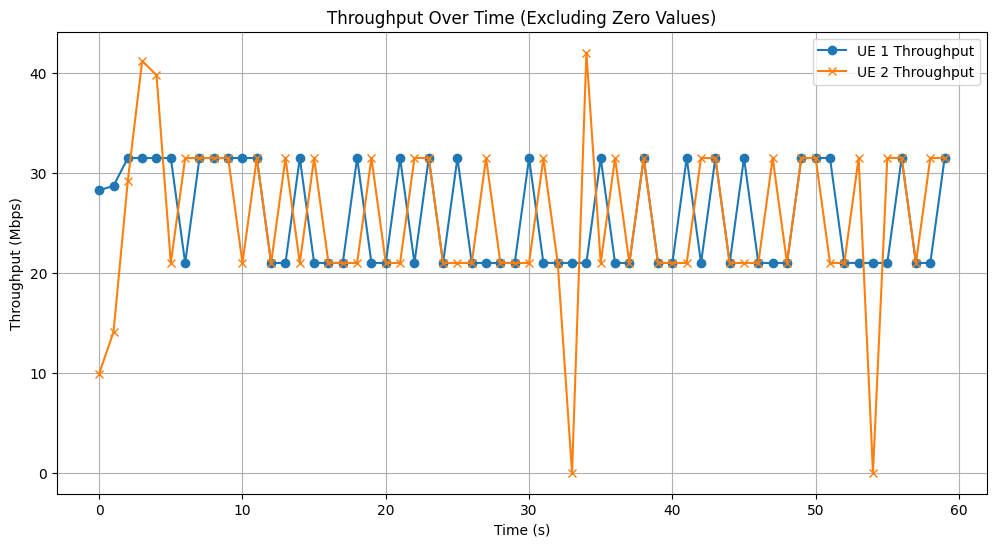

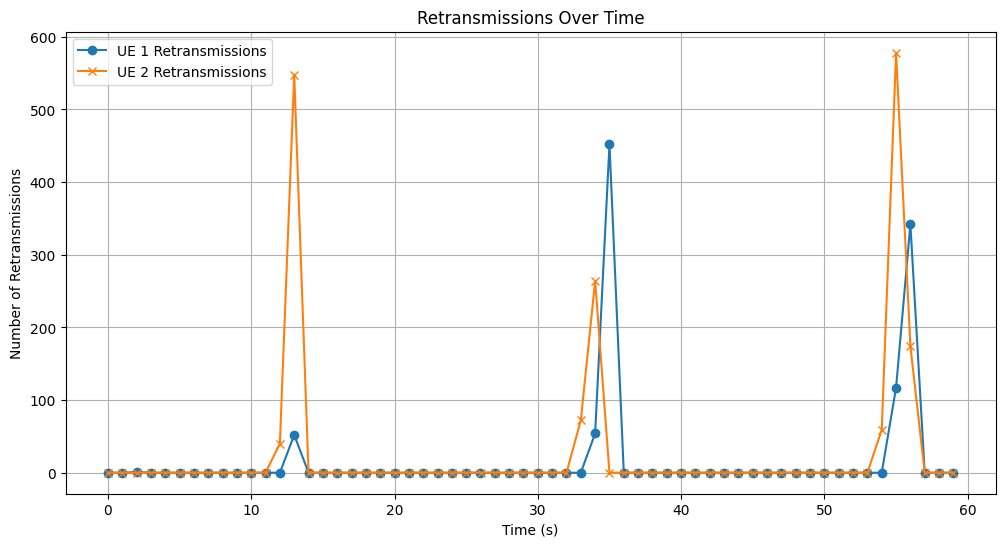

In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with the paths to your actual iperf JSON result files
file1 = 'cubic_ecn_none-result-ue1.json'
file2 = 'cubic_ecn_none-result-ue2.json'

def load_iperf_data(filename):
    """Load iperf JSON data from a file and return a pandas DataFrame."""
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Initialize lists to store the extracted data
    intervals = data['intervals']
    start_times = []
    end_times = []
    durations = []
    throughputs = []
    retransmissions = []
    
    # Iterate over each interval in the data
    for interval in intervals:
        sum_data = interval['sum']
        start_times.append(sum_data['start'])
        end_times.append(sum_data['end'])
        durations.append(sum_data['seconds'])
        # Convert throughput from bits per second to megabits per second
        throughput_mbps = sum_data['bits_per_second'] / 1_000_000  # Divide by 1,000,000
        throughputs.append(throughput_mbps)
        retransmissions.append(sum_data.get('retransmits', 0))  # Retransmits might not be present in UDP tests
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Start Time': start_times,
        'End Time': end_times,
        'Duration': durations,
        'Throughput (Mbps)': throughputs,
        'Retransmissions': retransmissions
    })
    
    return df

def filter_zero_throughput(df):
    """Filter out data points where throughput is zero."""
    return df[df['Throughput (Mbps)'] != 0].reset_index(drop=True)

# Load data from both files
df1 = load_iperf_data(file1)
df2 = load_iperf_data(file2)

# Filter out zero throughput data points for plotting throughput
# df1_nonzero = filter_zero_throughput(df1)
# df2_nonzero = filter_zero_throughput(df2)

# Calculate overall throughput and average retransmissions for each dataset
overall_throughput1 = df1['Throughput (Mbps)'].mean()
average_retransmits1 = df1['Retransmissions'].mean()

overall_throughput2 = df2['Throughput (Mbps)'].mean()
average_retransmits2 = df2['Retransmissions'].mean()

print(f"UE 1 - Overall Throughput: {overall_throughput1:.2f} Mbps")
print(f"UE 1 - Average Retransmissions: {average_retransmits1:.2f}")

print(f"\nUE 2 - Overall Throughput: {overall_throughput2:.2f} Mbps")
print(f"UE 2 - Average Retransmissions: {average_retransmits2:.2f}")

# Plotting the throughputs over time (excluding zero throughput data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Throughput (Mbps)'], label='UE 1 Throughput', marker='o')
plt.plot(df2['Start Time'], df2['Throughput (Mbps)'], label='UE 2 Throughput', marker='x')
plt.title('Throughput Over Time (Excluding Zero Values)')
plt.xlabel('Time (s)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the retransmissions over time (include all data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Retransmissions'], label='UE 1 Retransmissions', marker='o')
plt.plot(df2['Start Time'], df2['Retransmissions'], label='UE 2 Retransmissions', marker='x')
plt.title('Retransmissions Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Retransmissions')
plt.legend()
plt.grid(True)
plt.show()


COMMENT: the cwnd calculation is not showing the expected result. 

In [9]:

name_tx0="cubic_ecn_none"


# the csv files generated is of the following format
# timestamp, fd, cwnd, srtt

file_out_tx0_csv = name_tx0+"-ss.csv"

for ue_id in range(1, 3):
    print("Running to generate csv files " + name_tx0)

    ss_tx0_script_processing="""

    f_1={types}; 
    ue_id={ue_id};
    rm -f ${{f_1}}-ss-${{ue_id}}.csv;
    cat ${{f_1}}-ss-${{ue_id}}.txt | sed -e ":a; /<->$/ {{ N; s/<->\\n//; ba; }}"  | grep "iperf3" | grep -v "SYN-SENT"> ${{f_1}}-ss-processed-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | awk '{{print $1}}' > ts-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bcwnd:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' ' > cwnd-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\brtt:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' '  | cut -d '/' -f 1   > srtt-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bfd=.*?(\s|$)' | awk -F '[=,]' '{{print $2}}' | tr -d ')' | tr -d ' '   > fd-${{f_1}}-${{ue_id}}.txt;
    paste ts-${{f_1}}-${{ue_id}}.txt fd-${{f_1}}-${{ue_id}}.txt cwnd-${{f_1}}-${{ue_id}}.txt srtt-${{f_1}}-${{ue_id}}.txt -d ',' > ${{f_1}}-ss-${{ue_id}}.csv;""".format(types=name_tx0, ue_id="ue"+str(ue_id))

    tx.run(ss_tx0_script_processing)

tx.get("cubic_ecn_none"+"-ss-ue1.csv")
tx.get("cubic_ecn_none"+"-ss-ue2.csv")


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_38096\2911777773.py:12: SyntaxWarning: invalid escape sequence '\s'
  ss_tx0_script_processing="""


Running to generate csv files cubic_ecn_none
Running to generate csv files cubic_ecn_none


In [10]:
import json
import pandas as pd

throughput_data = {}
srtt_data = {}

# Dictionaries to hold data for each UE
cwnd_data = {}
srtt_data_time = {}

for ue_id in range(1, 3):
    name_tx0 = "cubic_ecn_none"
    ue_str = "ue" + str(ue_id)

    # Load the JSON output file into a Python object
    with open(f"{name_tx0}-result-{ue_str}.json") as f:
        iperf3_data = json.load(f)

    throughput_data[name_tx0 + ue_str] = iperf3_data['end']['sum_received']['bits_per_second'] / (1000000 * 1)  # to convert Mbit

    # Average SRTT for Each Flow
    columns = ['timestamp', 'flow ID', 'cwnd', 'srtt']
    df_f1 = pd.read_csv(f"{name_tx0}-ss-{ue_str}.csv", names=columns)

    # Filter out rows with flow ID = 4, they are for the control flows
    df_f1 = df_f1[df_f1['flow ID'] != 4].reset_index(drop=True)

    average_RTT_f1 = df_f1['srtt'].mean()

    # Normalize the timestamps to start from zero
    df_f1['timestamp'] = df_f1['timestamp'] - df_f1['timestamp'].iloc[0]

    # Save cwnd and srtt data into separate dataframes for each UE
    cwnd_data[ue_str] = df_f1[['timestamp', 'cwnd']]
    srtt_data_time[ue_str] = df_f1[['timestamp', 'srtt']]

    srtt_data[name_tx0 + ue_str] = average_RTT_f1

# Save throughput_data to a JSON file
with open('throughput_data.json', 'w') as f:
    json.dump(throughput_data, f)

# Save srtt_data to a JSON file
with open('srtt_data.json', 'w') as f:
    json.dump(srtt_data, f)

# Save cwnd_data and srtt_data_time to CSV files for each UE
for ue_str in cwnd_data.keys():
    cwnd_data[ue_str].to_csv(f"cwnd_data_{ue_str}.csv", index=False)
    srtt_data_time[ue_str].to_csv(f"srtt_data_time_{ue_str}.csv", index=False)


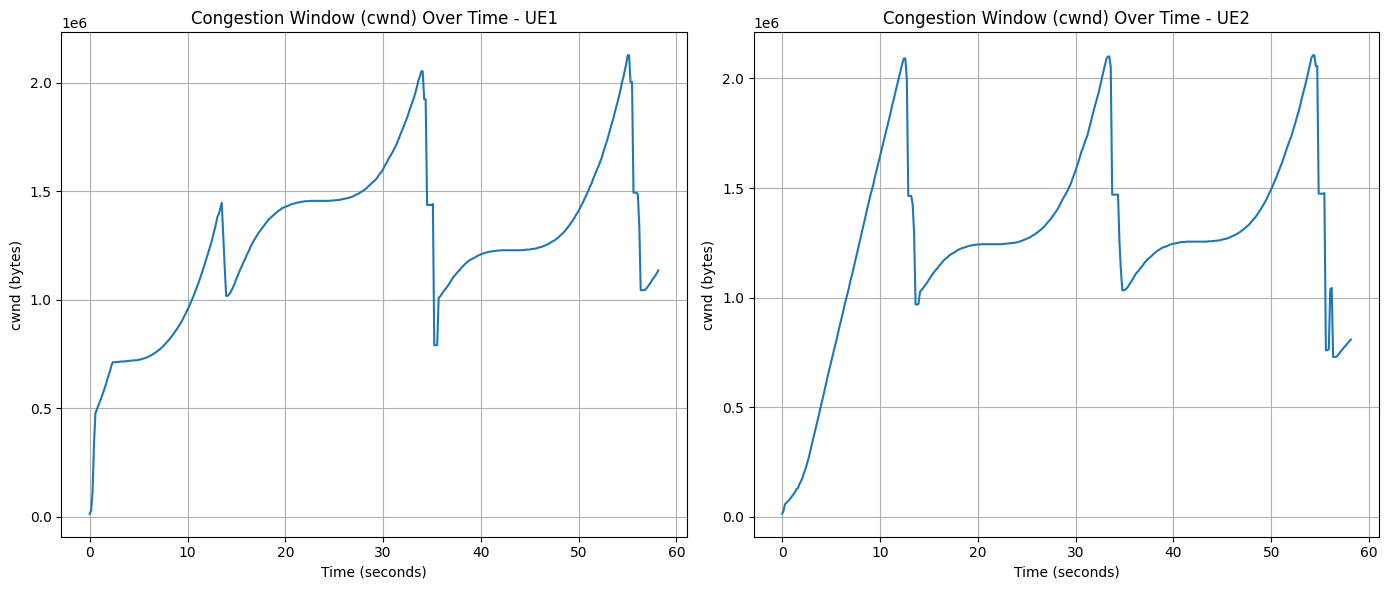

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize lists to hold data
timestamps = []
cwnds = []
ue_ids = []

# Loop through UEs to read their data
for ue_id in range(1, 3):
    ue_str = "ue" + str(ue_id)
    filename = f'cwnd_data_{ue_str}.csv'
    
    # Read the CSV file for the UE
    df = pd.read_csv(filename)
    
    # Append data to lists
    timestamps.append(df['timestamp'])
    cwnds.append(df['cwnd'] * 1448)  # Convert cwnd to bytes
    ue_ids.append(ue_str)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for each UE
for i, ue_str in enumerate(ue_ids):
    axes[i].plot(timestamps[i], cwnds[i], marker='', label=ue_str)
    axes[i].set_title(f'Congestion Window (cwnd) Over Time - {ue_str.upper()}')
    axes[i].set_xlabel('Time (seconds)')
    axes[i].set_ylabel('cwnd (bytes)')
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [12]:
router.get("monitor.log")

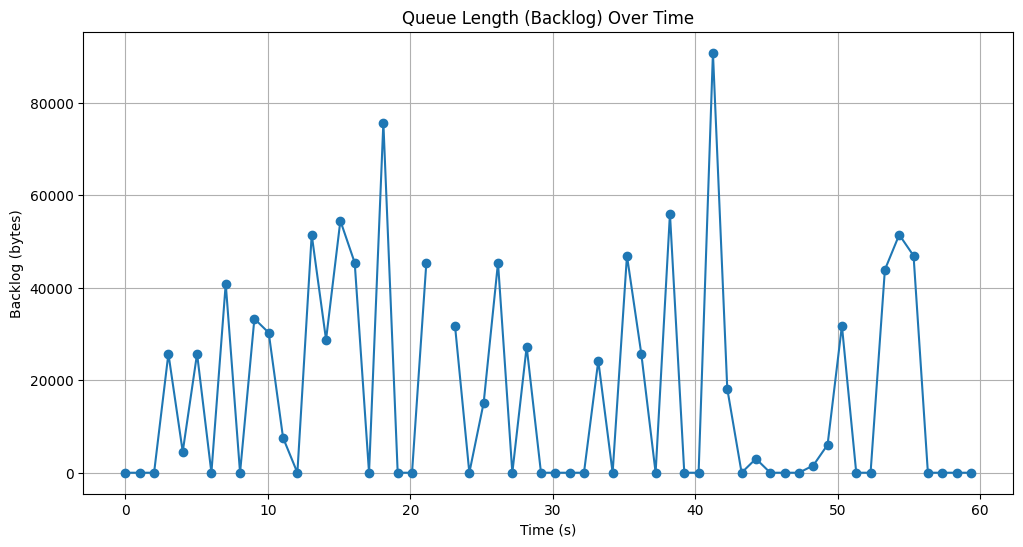

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16    526.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
30      0.0
31      0.0
32      0.0
33      0.0
34      0.0
35      0.0
36      0.0
37    210.0
38    452.0
39      0.0
40      0.0
41      0.0
42      0.0
43      0.0
44      0.0
45      0.0
46      0.0
47      0.0
48      0.0
49      0.0
50      0.0
51      0.0
52      0.0
53      0.0
54      0.0
55      0.0
56      0.0
57      0.0
58    485.0
59    516.0
Name: Dropped Packets Diff, dtype: float64


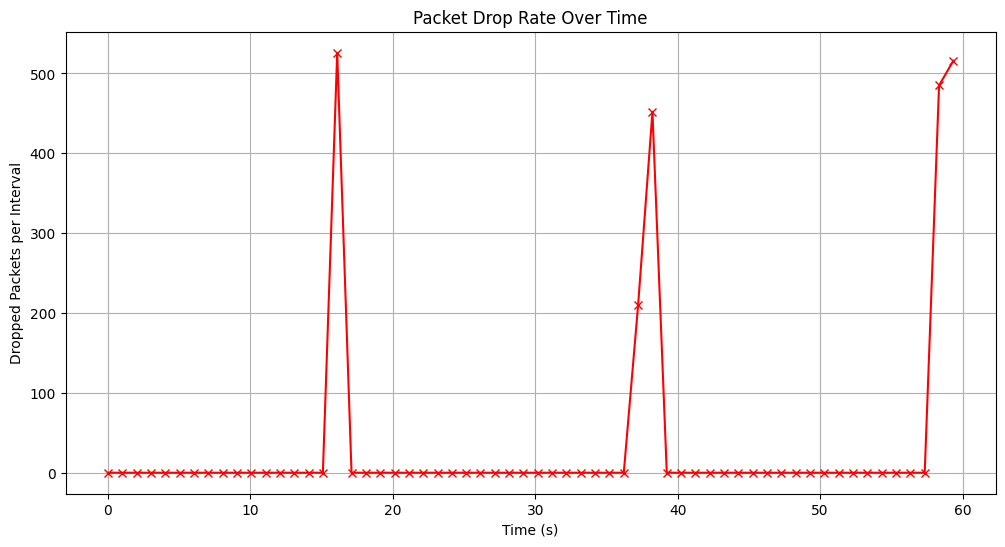

There is a backlog. Maximum backlog is 90840.0 bytes.


In [13]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your actual filename
filename = 'monitor.log'

def parse_qdisc_data(filename):
    """Parse qdisc data from a file and return a DataFrame."""
    timestamps = []
    sent_bytes = []
    sent_packets = []
    dropped_packets = []
    overlimits = []
    backlog_bytes = []
    backlog_packets = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            # Extract timestamp
            match_time = re.match(r'^(\d+\.\d+)', line)
            if match_time:
                timestamp = float(match_time.group(1))
                timestamps.append(timestamp)
            else:
                continue  # Skip line if timestamp not found

            # Extract bfifo qdisc statistics
            # Assuming 'qdisc bfifo' appears after 'qdisc htb' in the line
            bfifo_data = line.split('qdisc bfifo')[1]

            # Extract Sent bytes and packets
            match_sent = re.search(r'Sent\s+(\d+)\s+bytes\s+(\d+)\s+pkt', bfifo_data)
            if match_sent:
                sent_bytes.append(int(match_sent.group(1)))
                sent_packets.append(int(match_sent.group(2)))
            else:
                sent_bytes.append(None)
                sent_packets.append(None)

            # Extract dropped packets
            match_dropped = re.search(r'dropped\s+(\d+)', bfifo_data)
            if match_dropped:
                dropped_packets.append(int(match_dropped.group(1)))
            else:
                dropped_packets.append(None)

            # Extract overlimits
            match_overlimits = re.search(r'overlimits\s+(\d+)', bfifo_data)
            if match_overlimits:
                overlimits.append(int(match_overlimits.group(1)))
            else:
                overlimits.append(None)

            # Extract backlog bytes and packets
            match_backlog = re.search(r'backlog\s+(\d+)b\s+(\d+)p', bfifo_data)
            if match_backlog:
                backlog_bytes.append(int(match_backlog.group(1)))
                backlog_packets.append(int(match_backlog.group(2)))
            else:
                backlog_bytes.append(None)
                backlog_packets.append(None)

    # Create a DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Sent Bytes': sent_bytes,
        'Sent Packets': sent_packets,
        'Dropped Packets': dropped_packets,
        'Overlimits': overlimits,
        'Backlog Bytes': backlog_bytes,
        'Backlog Packets': backlog_packets
    })

    # Convert timestamps to relative time (seconds since start)
    df['Relative Time'] = df['Timestamp'] - df['Timestamp'].iloc[0]

    return df

def plot_queue_length(df):
    """Plot queue length (backlog) over time."""
    plt.figure(figsize=(12, 6))
    plt.plot(df['Relative Time'], df['Backlog Bytes'], marker='o')
    plt.title('Queue Length (Backlog) Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Backlog (bytes)')
    plt.grid(True)
    plt.show()

def plot_packet_drop_rate(df):
    """Plot packet drop rate over time."""
    # Calculate the difference in dropped packets between measurements
    df['Dropped Packets Diff'] = df['Dropped Packets'].diff().fillna(0)
    
    print(df['Dropped Packets Diff'])

    plt.figure(figsize=(12, 6))
    plt.plot(df['Relative Time'], df['Dropped Packets Diff'], marker='x', color='red')
    plt.title('Packet Drop Rate Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Dropped Packets per Interval')
    plt.grid(True)
    plt.show()

def analyze_backlog(df):
    """Analyze backlog and determine if there is a backlog."""
    max_backlog = df['Backlog Bytes'].max()
    if max_backlog > 0:
        print(f"There is a backlog. Maximum backlog is {max_backlog} bytes.")
    else:
        print("There is no backlog. The queue is empty throughout the measurements.")

# Main execution
df = parse_qdisc_data(filename)

# Plot queue length
plot_queue_length(df)

# Plot packet drop rate
plot_packet_drop_rate(df)

# Analyze backlog
analyze_backlog(df)


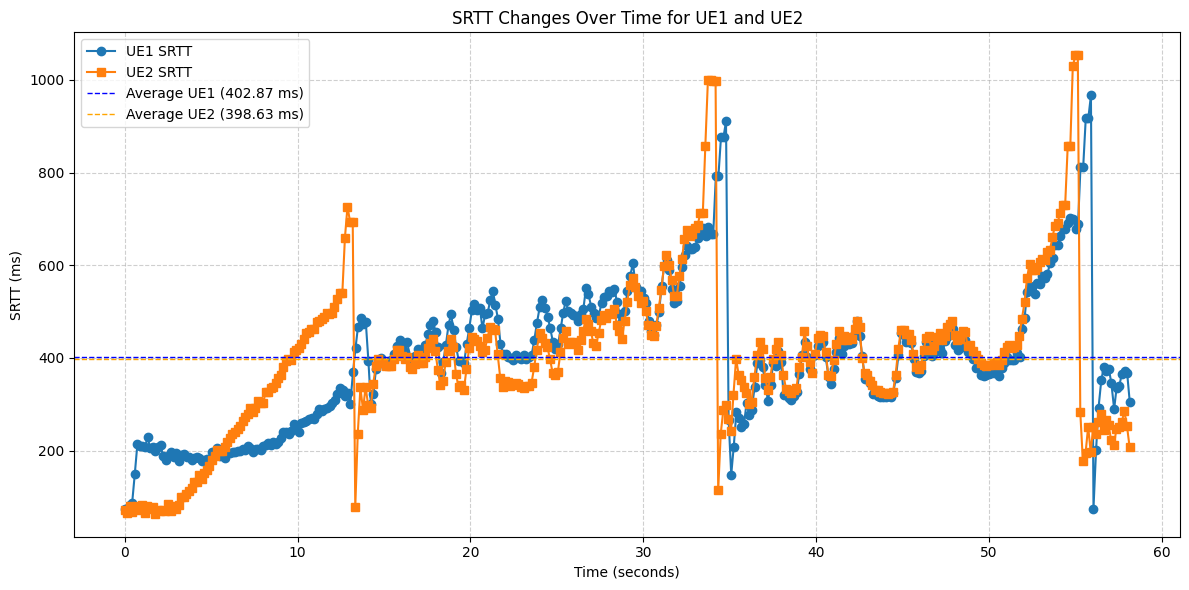

Average SRTT for UE1: 402.872 ms
Average SRTT for UE2: 398.628 ms


In [14]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read the SRTT data for each UE
ue1_file_path = 'srtt_data_time_ue1.csv'  # Replace with your actual filename for UE1
ue2_file_path = 'srtt_data_time_ue2.csv'  # Replace with your actual filename for UE2

# Reading the CSV files
df_ue1 = pd.read_csv(ue1_file_path)
df_ue2 = pd.read_csv(ue2_file_path)

# Normalize timestamps to start from zero for better comparison
df_ue1['timestamp'] = df_ue1['timestamp'] - df_ue1['timestamp'].iloc[0]
df_ue2['timestamp'] = df_ue2['timestamp'] - df_ue2['timestamp'].iloc[0]

# Calculate the average SRTT for each UE
avg_ue1 = df_ue1['srtt'].mean()
avg_ue2 = df_ue2['srtt'].mean()

# Plot the SRTT changes over time for both UE1 and UE2
plt.figure(figsize=(12, 6))
plt.plot(df_ue1['timestamp'], df_ue1['srtt'], label='UE1 SRTT', marker='o')
plt.plot(df_ue2['timestamp'], df_ue2['srtt'], label='UE2 SRTT', marker='s')

# Plot average lines for each UE
plt.axhline(y=avg_ue1, color='blue', linestyle='--', linewidth=1, label=f'Average UE1 ({avg_ue1:.2f} ms)')
plt.axhline(y=avg_ue2, color='orange', linestyle='--', linewidth=1, label=f'Average UE2 ({avg_ue2:.2f} ms)')

# Adding labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('SRTT (ms)')
plt.title('SRTT Changes Over Time for UE1 and UE2')

# Adding a legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

# Print the average SRTT for each UE
print(f"Average SRTT for UE1: {avg_ue1:.3f} ms")
print(f"Average SRTT for UE2: {avg_ue2:.3f} ms")
